reference: unet paper [https://arxiv.org/pdf/1505.04597]

In [1]:
import os
import cv2
import math
from PIL import Image
from tqdm import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
# import albumentations as A
# from albumentations.pytorch import ToTensorV2
from torchvision import transforms as T


root_path = "/kaggle/input/camvid/CamVid"
class_dict_path = os.path.join(root_path, "class_dict.csv")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
H = 704
W = 960
scale = 2
batch_size = 8

# Data pre processing / exploration

In [2]:
class CVDataset(Dataset):
    def __init__(self, path=root_path, split="train", class_dict_path=class_dict_path):
        self.root_path = path
        self.images_dir = os.path.join(self.root_path, split)
        self.masks_dir = os.path.join(self.root_path, f"{split}_labels")
        self._images = [f for f in sorted(os.listdir(self.images_dir))]
        self._masks = [f for f in sorted(os.listdir(self.masks_dir))]            
        self.n = T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        self.t = T.ToTensor()
        self.label_encoder = {
            (row['r'], row['g'], row['b']): idx
            for idx, row in pd.read_csv(class_dict_path).iterrows()
        }


    def __len__(self):
        return len(self._images)

    
    def _label_encoder(self, mask):
        h, w, _ = mask.shape
        encoded = np.zeros((h, w), dtype=np.int32)
        for r, g, b in self.label_encoder.keys():
            match = (mask[:, :, 0] == r) & (mask[:, :, 1] == g) & (mask[:, :, 2] == b)
            encoded[match] = self.label_encoder[(r, g, b)]
        return encoded
    
    def __getitem__(self, idx):
        image_name = self._images[idx]
        mask_name = self._masks[idx]

        image_path = os.path.join(self.images_dir, image_name)
        mask_path = os.path.join(self.masks_dir, mask_name)

        image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(mask_path), cv2.COLOR_BGR2RGB)
        mask = self._label_encoder(mask)
        image = cv2.resize(image, (H//scale, W//scale), interpolation=cv2.INTER_LINEAR)
        mask = cv2.resize(mask, (H//scale, W//scale), interpolation=cv2.INTER_NEAREST)

        if torch.randn(1).item() > 0:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask, 1)
        
        image, mask = self.t(image), self.t(mask)
        image = self.n(image)
        mask = mask.squeeze(0)

        return image, mask.long()

In [3]:
H, H/16, W, W/16, 44*16, 60*16

(704, 44.0, 960, 60.0, 704, 960)

In [4]:
train_dataset = CVDataset(root_path, split="train")
test_dataset = CVDataset(root_path, split="test")
val_dataset = CVDataset(root_path, split="val")

num_workers=4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [5]:
for image, mask in val_loader:
    print(image.size(), mask.size())
    print(image.dtype, mask.dtype)
    break

torch.Size([8, 3, 480, 352]) torch.Size([8, 480, 352])
torch.float32 torch.int64


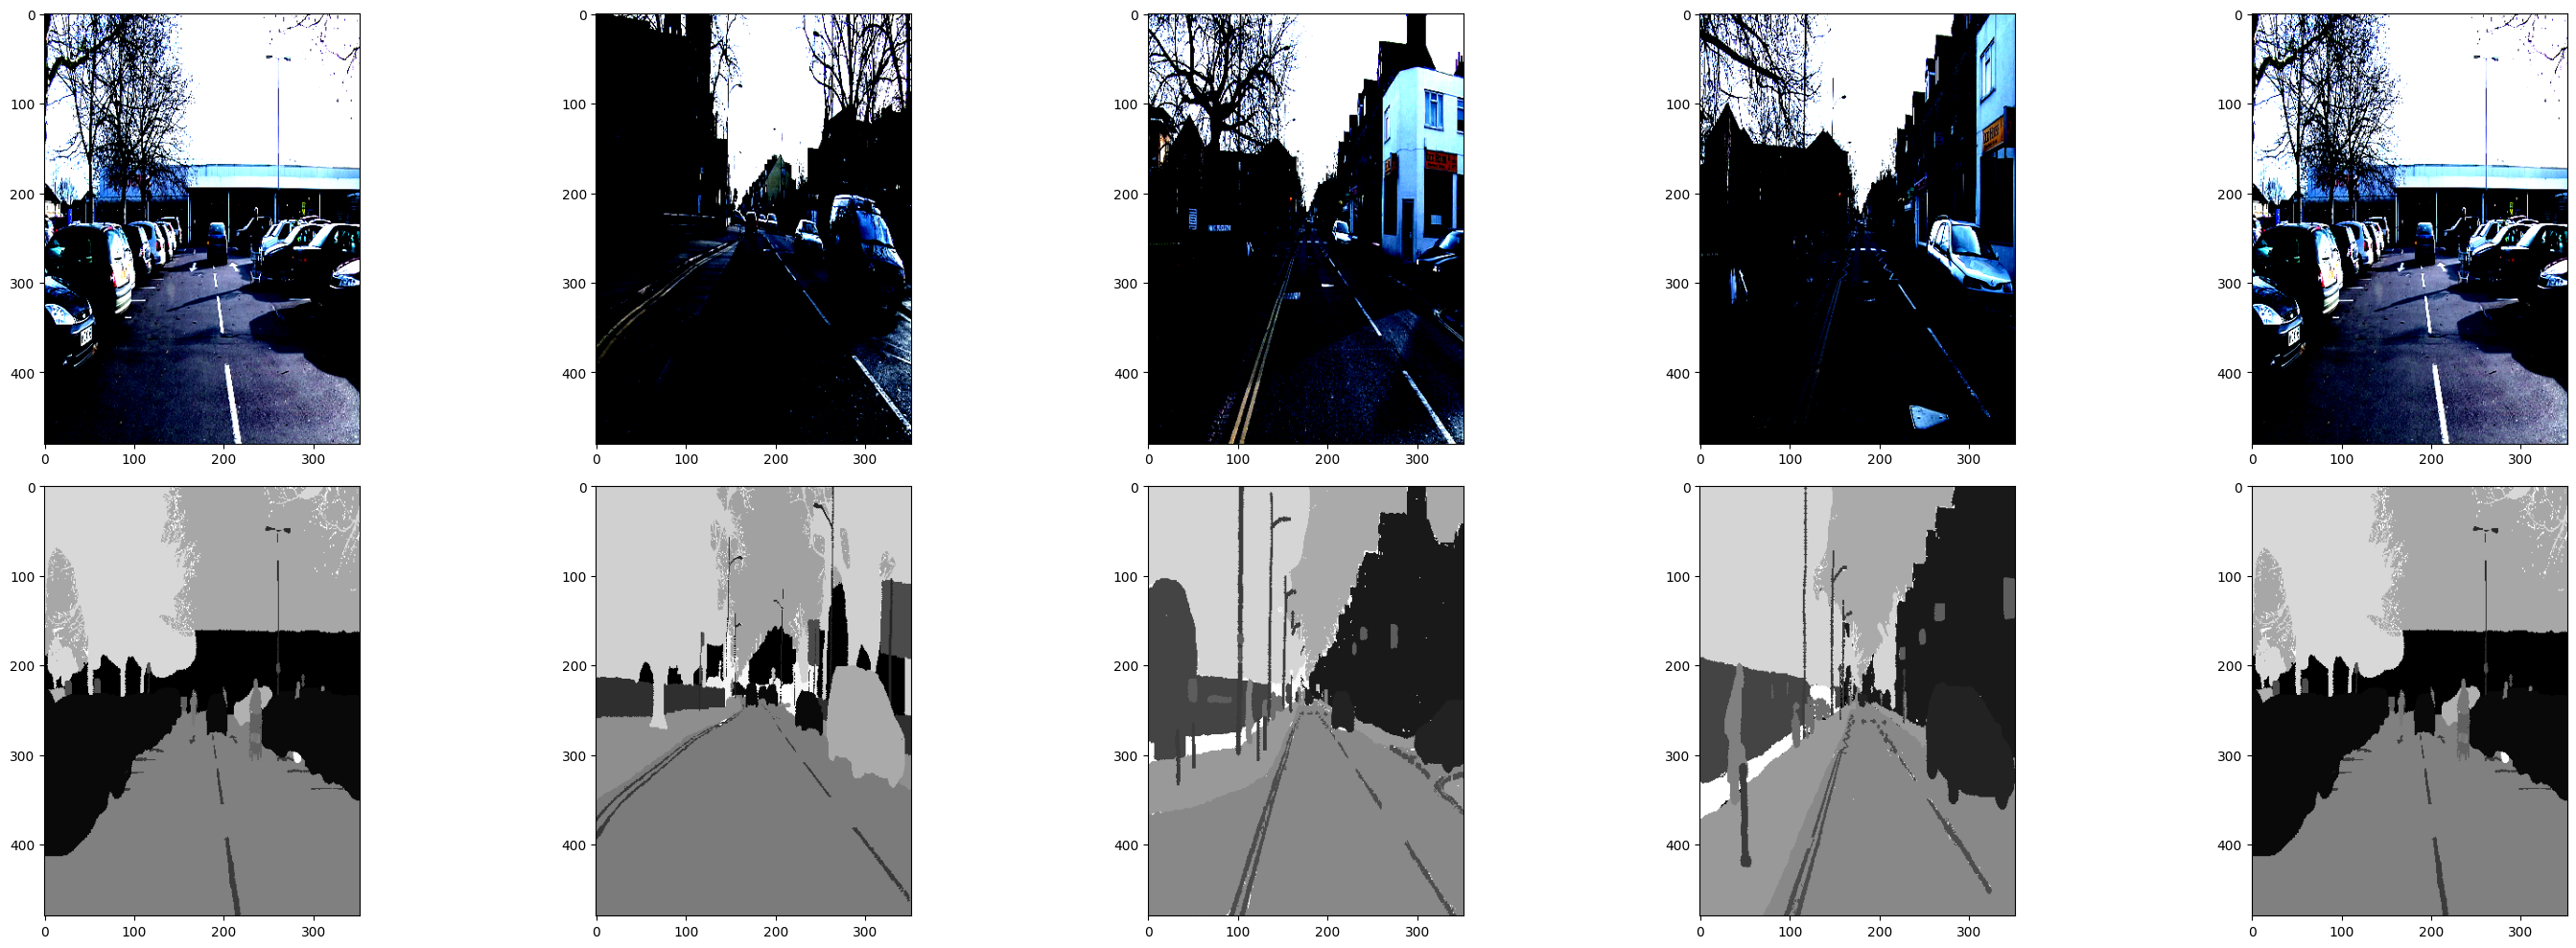

In [6]:
image = image[:4]
mask = mask[:4]
num_rows = 2
num_cols = len(image) + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))

for i in range(num_cols):
    axes[0, i].imshow(image[i%len(image)].permute(1, 2, 0))
    axes[1, i].imshow(mask[i%len(image)], cmap="gray")

plt.tight_layout()
plt.show()

In [7]:
image.min(), image.max(), image.float().mean(), image.float().std()

(tensor(-2.1008), tensor(2.6400), tensor(-0.0062), tensor(1.3221))

# Model Definition: U-Net 

In [8]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1)
        self.activation = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        x = self.activation(self.conv1(x))
        x = self.bn1(x)
        x = self.activation(self.conv2(x))
        return self.bn2(x)
        

In [9]:
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # print(in_channels, out_channels)
        self.conv = ConvBlock(in_channels, out_channels)
        self.down = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

    def forward(self, x):
        # print(x.size())
        skip_connection = self.conv(x)
        down = self.down(skip_connection)
        return down, skip_connection

class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # print(in_channels, out_channels)
        self.conv = ConvBlock(in_channels, out_channels)
        self.up = nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2, padding=0)

    def forward(self, x, skip):
        # print(x.size(), skip.size())
        x = self.up(x)
        # print("uuuuuuuuuuuuu", x.size(), skip.size())
        x = torch.cat([x, skip], dim=1)
        # x = self.conv(x)
        return self.conv(x)

In [10]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # up/dow i: conv block at level i
        
        # concatenation_path
        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)

        self.bottle_neck = ConvBlock(512, 1024)
        
        # expansion_path
        self.up4 = UpSample(1024, 512)
        self.up3 = UpSample(512, 256)
        self.up2 = UpSample(256, 128)
        self.up1 = UpSample(128, 64)

        self.out = nn.Conv2d(64, out_channels, kernel_size=1)

        
        
    def forward(self, x):
        x, skip1 = self.down1(x)        
        x, skip2 = self.down2(x)
        x, skip3 = self.down3(x)        
        x, skip4 = self.down4(x)

        x = self.bottle_neck(x)

        x = self.up4(x, skip4)
        x = self.up3(x, skip3)
        x = self.up2(x, skip2)
        x = self.up1(x, skip1)

        return self.out(x)

In [11]:
def compute_class_weights(loader, num_classes, device):
    classes_counter = torch.zeros(num_classes)
    smoother = 1e-6
    for _, mask in tqdm(loader):
        mask = mask.view(-1)
        classes_counter += torch.bincount(mask, minlength=num_classes)
    
    total = classes_counter.sum().item()
    class_weights = total / (classes_counter + smoother)
    
    class_weights /= class_weights.sum()
    return class_weights.to(device)

In [12]:
num_classes = len(train_dataset.label_encoder)

In [13]:
class_weights = compute_class_weights(train_loader, num_classes, device)

100%|██████████| 47/47 [00:24<00:00,  1.89it/s]


In [14]:
class_weights, num_classes

(tensor([3.3591e-10, 3.3918e-11, 3.3878e-12, 3.7591e-11, 7.0222e-14, 5.1436e-13,
         6.1805e-11, 5.1138e-11, 1.5511e-12, 9.6060e-13, 8.5966e-13, 1.4333e-10,
         2.4451e-12, 2.8736e-10, 3.4156e-12, 4.5616e-12, 2.5904e-12, 5.6348e-14,
         6.5784e-12, 2.3465e-13, 1.2336e-11, 1.0576e-13, 3.0242e-12, 4.1494e-10,
         4.4174e-12, 1.0000e+00, 1.5831e-13, 8.6179e-12, 1.0000e-06, 1.9530e-12,
         6.1136e-13, 1.3014e-12], device='cuda:0'),
 32)

In [15]:
class_weights[-4] *= 1e-3
class_weights[-7] *= 1e-9
a = (class_weights - class_weights.mean()) / class_weights.std()
a = (a - a.min()) / (a.max() - a.min())
a = a + a.mean()
a /= a.sum()
a

tensor([0.0647, 0.0206, 0.0161, 0.0211, 0.0156, 0.0157, 0.0246, 0.0231, 0.0158,
        0.0158, 0.0157, 0.0365, 0.0160, 0.0576, 0.0161, 0.0163, 0.0160, 0.0156,
        0.0166, 0.0157, 0.0174, 0.0156, 0.0161, 0.0762, 0.0163, 0.1616, 0.0156,
        0.0169, 0.1616, 0.0159, 0.0157, 0.0158], device='cuda:0')

In [16]:
class_weights = a

In [17]:
class_weights

tensor([0.0647, 0.0206, 0.0161, 0.0211, 0.0156, 0.0157, 0.0246, 0.0231, 0.0158,
        0.0158, 0.0157, 0.0365, 0.0160, 0.0576, 0.0161, 0.0163, 0.0160, 0.0156,
        0.0166, 0.0157, 0.0174, 0.0156, 0.0161, 0.0762, 0.0163, 0.1616, 0.0156,
        0.0169, 0.1616, 0.0159, 0.0157, 0.0158], device='cuda:0')

In [18]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0, reduction='sum'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)  # Get probabilities
        focal_loss = self.alpha * (1 - pt) ** self.gamma * ce_loss

        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


In [19]:
epochs = 80
learning_rate = 1e-3
num_classes = len(train_dataset.label_encoder)

model = UNet(3, num_classes).to(device)

# using a slightly high first momentum coef to compensate for the low batch size
optimizer = optim.AdamW(model.parameters(), learning_rate, weight_decay=.01, betas=(.95, .999))

lr_scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=learning_rate,
    epochs=epochs,
    steps_per_epoch=len(train_loader),
    pct_start=0.2,
    div_factor=20,
    final_div_factor=200
)
criterion = FocalLoss(alpha=1.0, gamma=2.0)
# tracker = MetricsTracker(num_classes, device)

# Model training

In [20]:
smoother = 1e-6

@torch.no_grad()
def dice(pred, target):
    pred = pred.argmax(1)
    
    dice = 0
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        intersection = (pred_mask & target_mask).sum(dim=(1, 2))
        union = pred_mask.sum(dim=(1, 2)) + target_mask.sum(dim=(1, 2))
        dice += (2 * intersection / (union + smoother)).mean() * class_weights[cls]

    dice = dice / num_classes
    return dice

@torch.no_grad()
def iou(pred, target):
    iou = 0
    pred = pred.argmax(1)
    
    for cls in range(num_classes):
        pred_mask = (pred == cls)
        target_mask = (target == cls)
        
        intersection = (pred_mask & target_mask).sum(dim=(1, 2))
        union = (pred_mask | target_mask).sum(dim=(1, 2))
        
        iou_per_sample = intersection / (union + 1e-6)
        
        iou += iou_per_sample.mean() * class_weights[cls]
    iou = iou / num_classes
    return iou

@torch.no_grad()
def accuracy(pred, target):
    pred = pred.argmax(1)
    correct = (pred == target)
    accuracy = 0

    for cls in range(num_classes):
        class_mask = (target == cls)
        total_class_pixels = class_mask.sum(dim=(1, 2))

        valid_samples = total_class_pixels > 0
        if valid_samples.any():
            correct_class = (correct * class_mask).sum(dim=(1, 2))
            acc_per_sample = correct_class[valid_samples] / total_class_pixels[valid_samples]
            accuracy += acc_per_sample.mean() * class_weights[cls]

    accuracy = accuracy / num_classes
    return accuracy

* note: performance metrics aren't that accurate due to high classes variance & imbalance

100%|██████████| 47/47 [00:32<00:00,  1.44it/s]


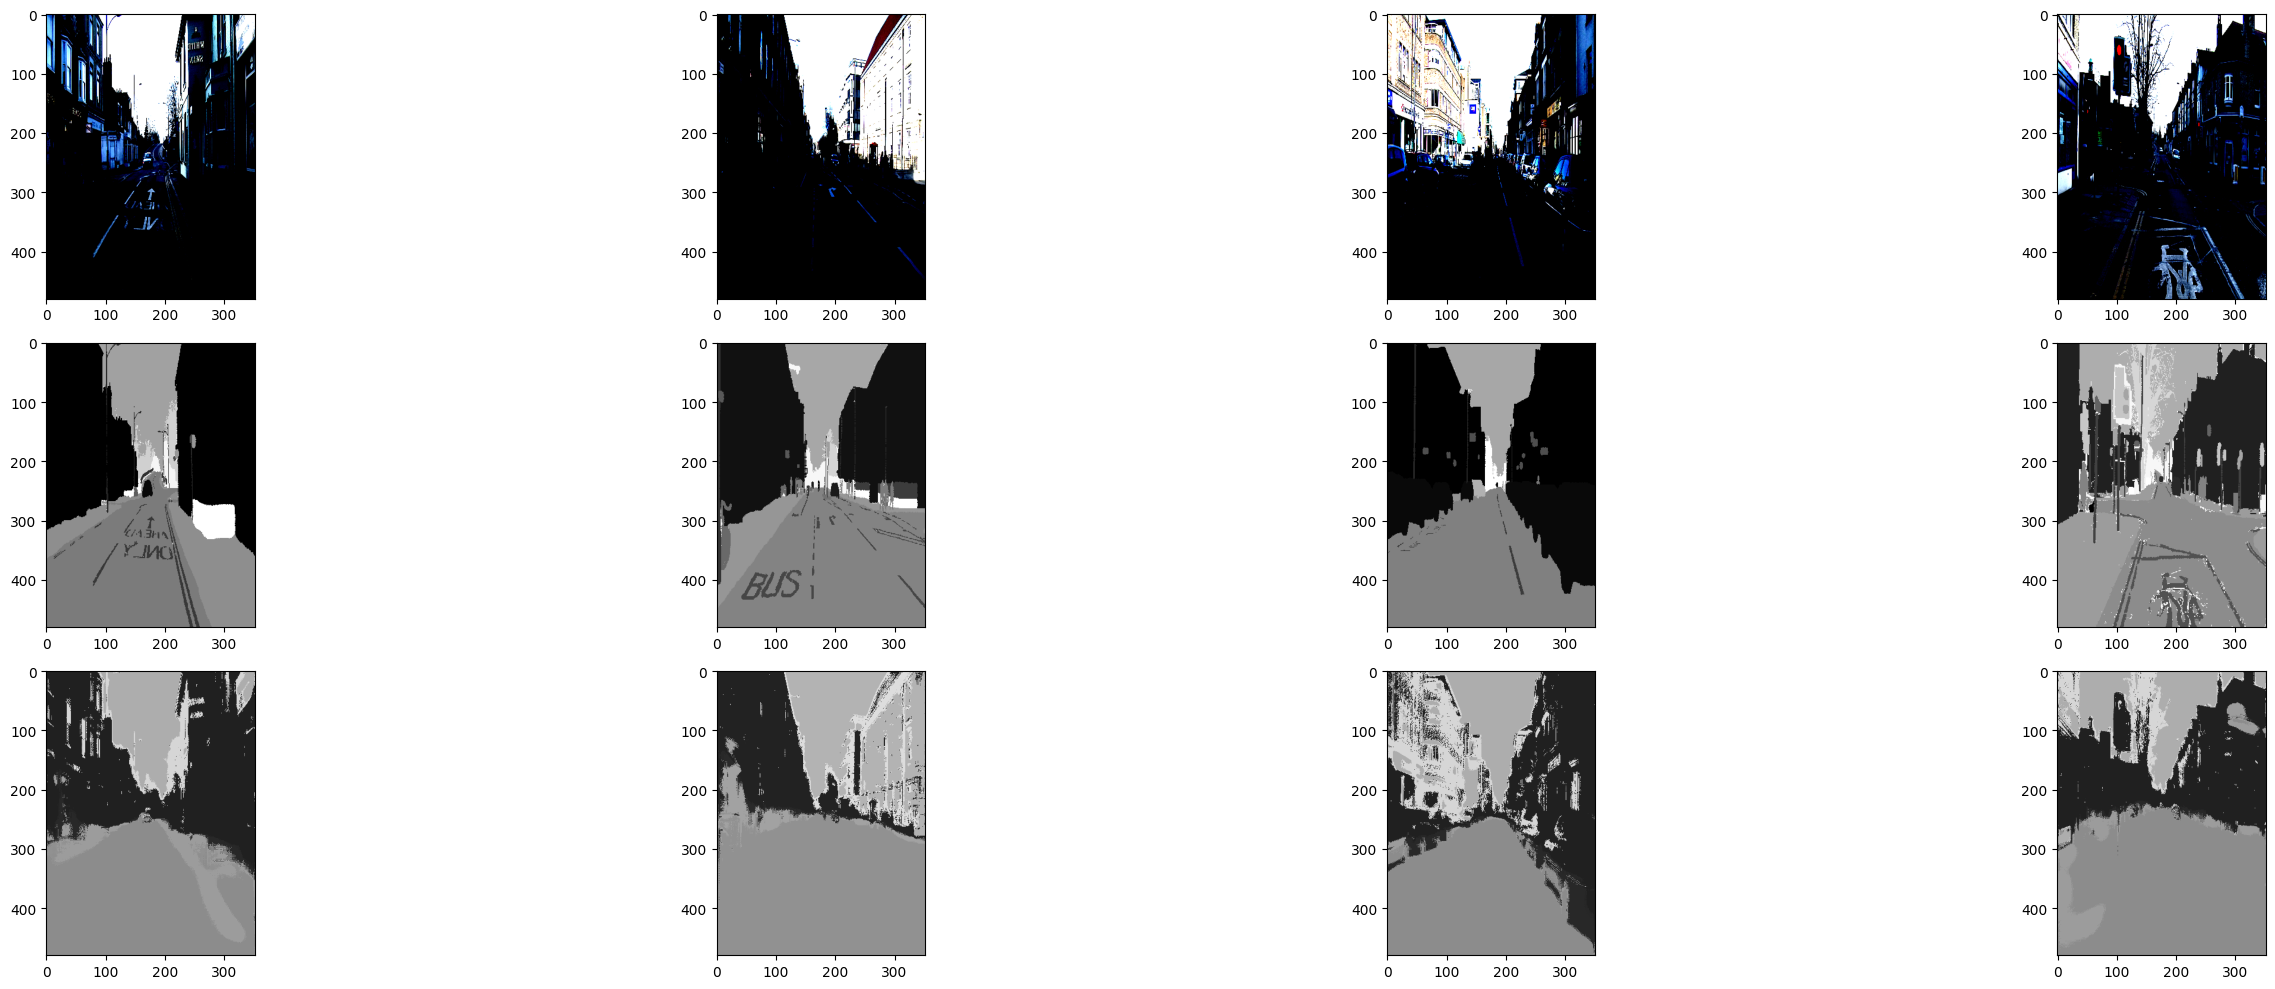

epoch 1/80 loss: 2688111.5724734045, acc: 0.0014311184640973806, dic: 0.0012567113153636456, iou: 0.0009800477419048548
epoch 1/80 val_loss: 1806070.4903846155, val_acc: 0.0016198018565773964, val_dic: 0.0014050788013264537, val_iou: 0.0011308141984045506


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 2/80 loss: 1487712.7912234042, acc: 0.002090700902044773, dic: 0.0017847984563559294, iou: 0.001484928303398192
epoch 2/80 val_loss: 1179003.0336538462, val_acc: 0.002158091403543949, val_dic: 0.0018679634667932987, val_iou: 0.0015702435048297048


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 3/80 loss: 1173727.791555851, acc: 0.002320669125765562, dic: 0.001967195887118578, iou: 0.0016673956997692585
epoch 3/80 val_loss: 961892.8701923077, val_acc: 0.0024883230216801167, val_dic: 0.0021415608935058117, val_iou: 0.001847381703555584


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 4/80 loss: 981680.3344414893, acc: 0.002509337617084384, dic: 0.0021287985146045685, iou: 0.0018151885597035289
epoch 4/80 val_loss: 1049306.0673076923, val_acc: 0.002330385148525238, val_dic: 0.002035470213741064, val_iou: 0.001703733461908996


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 5/80 loss: 913760.8277925532, acc: 0.0026490536984056234, dic: 0.0022769453935325146, iou: 0.001916989916935563
epoch 5/80 val_loss: 1368910.548076923, val_acc: 0.0023686871863901615, val_dic: 0.00192077097017318, val_iou: 0.001578928204253316


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 6/80 loss: 822673.4507978724, acc: 0.0028823644388467073, dic: 0.002439044415950775, iou: 0.0020478253718465567
epoch 6/80 val_loss: 831904.8028846154, val_acc: 0.0027291870210319757, val_dic: 0.0023967742454260588, val_iou: 0.0020102427806705236


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 7/80 loss: 798815.5831948138, acc: 0.0028799939900636673, dic: 0.0024590257089585066, iou: 0.0020562142599374056
epoch 7/80 val_loss: 983363.4471153846, val_acc: 0.0026204416062682867, val_dic: 0.0022258106619119644, val_iou: 0.001865238300524652


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 8/80 loss: 759655.0629986703, acc: 0.002977972850203514, dic: 0.0025193621404469013, iou: 0.0021062761079519987
epoch 8/80 val_loss: 733066.0600961539, val_acc: 0.003203309839591384, val_dic: 0.00261153862811625, val_iou: 0.002164259320124984


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 9/80 loss: 696667.109375, acc: 0.0031213313341140747, dic: 0.00261711492203176, iou: 0.0021832825150340796
epoch 9/80 val_loss: 742281.9927884615, val_acc: 0.0033516252879053354, val_dic: 0.0027402869891375303, val_iou: 0.0022653581108897924


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 10/80 loss: 660469.0797872341, acc: 0.003248866181820631, dic: 0.002718334784731269, iou: 0.002252386650070548
epoch 10/80 val_loss: 736774.4591346154, val_acc: 0.002875491976737976, val_dic: 0.0024842293933033943, val_iou: 0.0020864035468548536


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


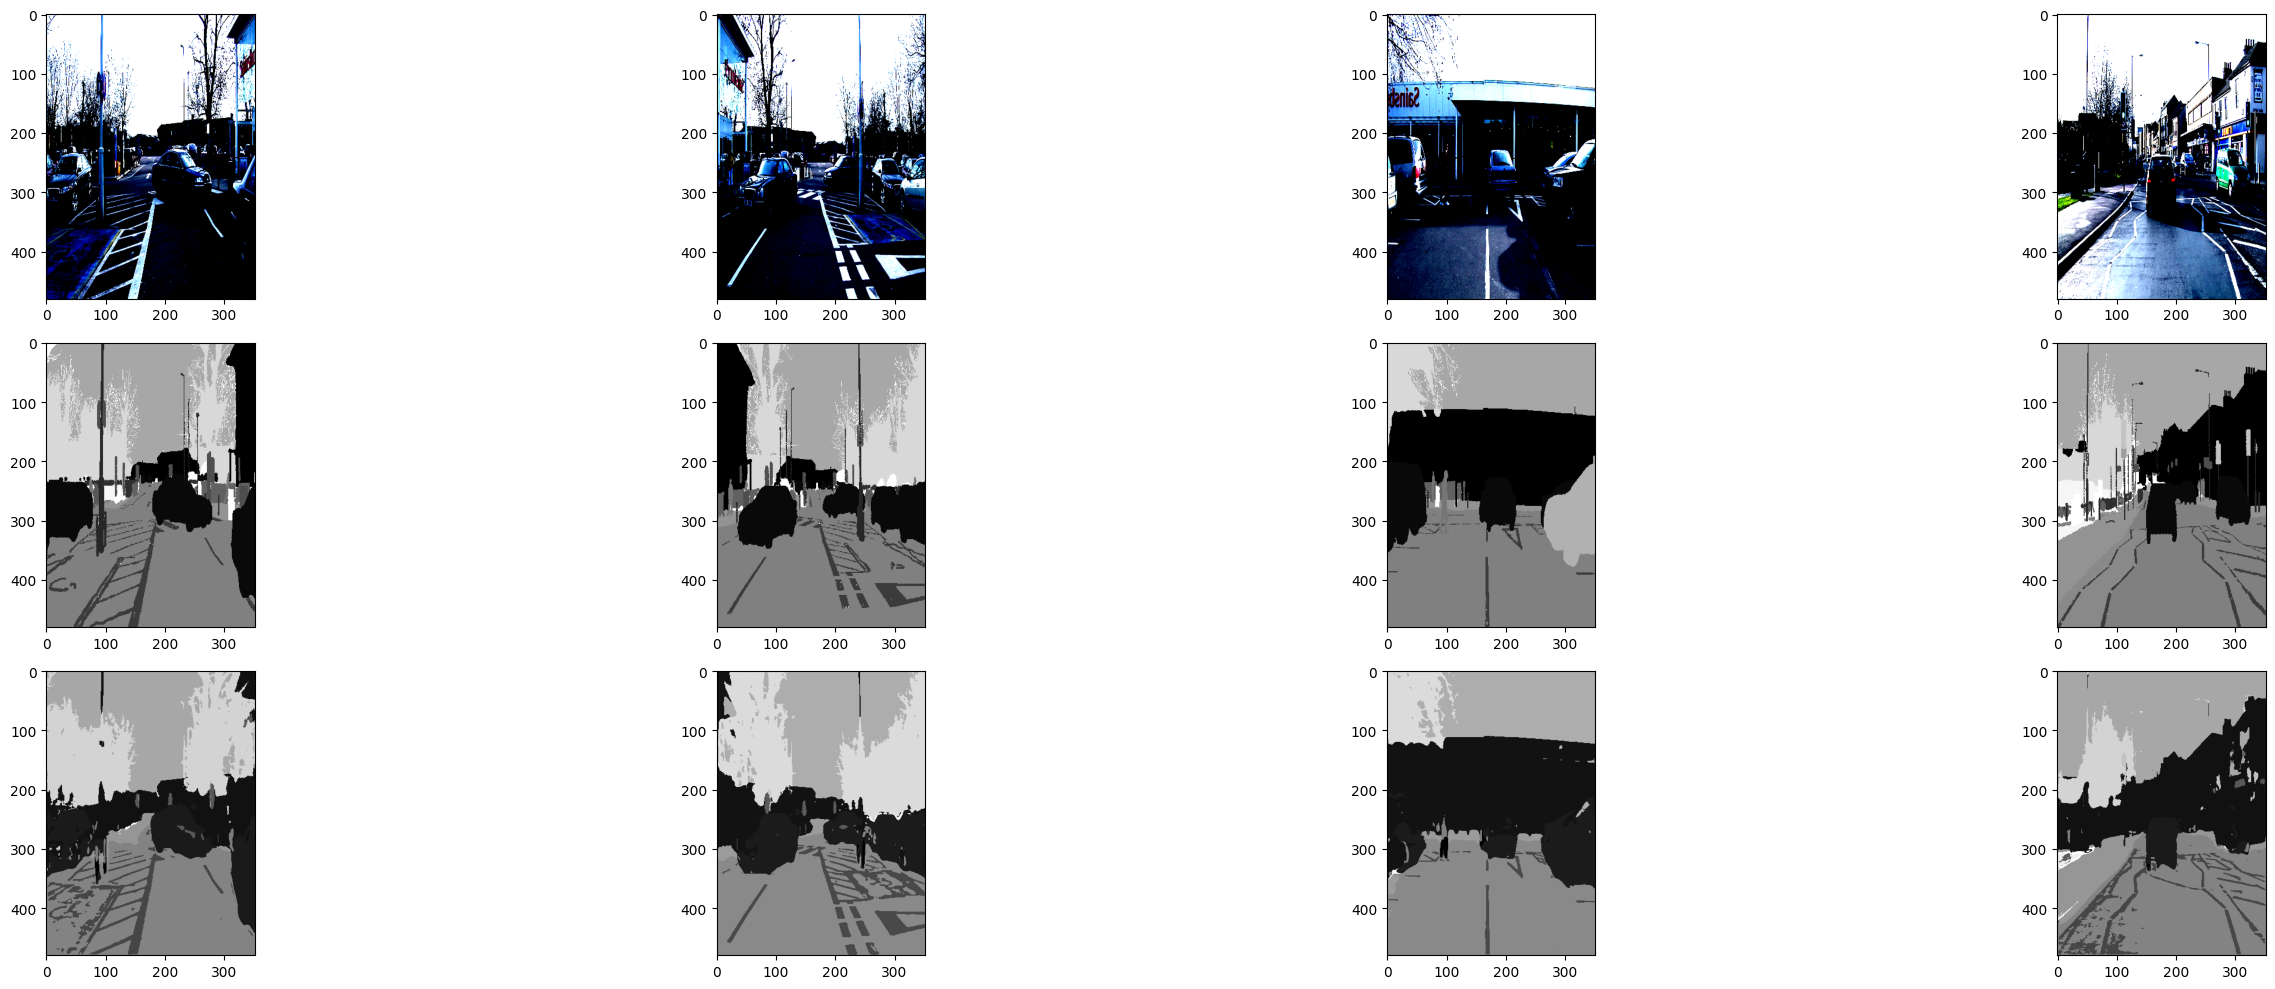

epoch 11/80 loss: 602744.3317819149, acc: 0.003390540601685643, dic: 0.0028704667929559946, iou: 0.0023814779706299305
epoch 11/80 val_loss: 781893.2451923077, val_acc: 0.002861305605620146, val_dic: 0.0025801125448197126, val_iou: 0.0021575596183538437


100%|██████████| 47/47 [00:32<00:00,  1.46it/s]


epoch 12/80 loss: 569896.2067819149, acc: 0.0034657283686101437, dic: 0.0029376570601016283, iou: 0.0024319037329405546
epoch 12/80 val_loss: 694868.8870192308, val_acc: 0.003423860529437661, val_dic: 0.0028632469475269318, val_iou: 0.0023702403996139765


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 13/80 loss: 545492.8612034575, acc: 0.0035961896646767855, dic: 0.003047898644581437, iou: 0.002525571035221219
epoch 13/80 val_loss: 755685.9663461539, val_acc: 0.0032936835195869207, val_dic: 0.0026953539345413446, val_iou: 0.00217518606223166


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 14/80 loss: 530837.2012965425, acc: 0.0037427889183163643, dic: 0.0031502281781286, iou: 0.0026089316233992577
epoch 14/80 val_loss: 585922.2716346154, val_acc: 0.003422290552407503, val_dic: 0.002951441565528512, val_iou: 0.002438989467918873


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 15/80 loss: 503501.3756648936, acc: 0.0038099477533251047, dic: 0.0032040500082075596, iou: 0.0026469118893146515
epoch 15/80 val_loss: 1107906.2836538462, val_acc: 0.002981775440275669, val_dic: 0.0025898590683937073, val_iou: 0.002114964183419943


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 16/80 loss: 489734.9960106383, acc: 0.003812891896814108, dic: 0.003204985987395048, iou: 0.0026514744386076927
epoch 16/80 val_loss: 701033.1947115385, val_acc: 0.0032857481855899096, val_dic: 0.00284037203527987, val_iou: 0.002310971962288022


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 17/80 loss: 468696.46010638296, acc: 0.003981988411396742, dic: 0.0033367276191711426, iou: 0.002769071375951171
epoch 17/80 val_loss: 582850.5721153846, val_acc: 0.003810267662629485, val_dic: 0.0030541974119842052, val_iou: 0.002514079213142395


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 18/80 loss: 456429.5784574468, acc: 0.003981723450124264, dic: 0.00334016140550375, iou: 0.002771661849692464
epoch 18/80 val_loss: 585028.2848557692, val_acc: 0.0035930729936808348, val_dic: 0.0030201771296560764, val_iou: 0.0024717252235859632


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 19/80 loss: 421400.0201130319, acc: 0.004099505953490734, dic: 0.0034394662361592054, iou: 0.0028638008516281843
epoch 19/80 val_loss: 630297.2307692308, val_acc: 0.003986806608736515, val_dic: 0.0031542438082396984, val_iou: 0.002563779940828681


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 20/80 loss: 416704.9536236702, acc: 0.004179645329713821, dic: 0.0035282541066408157, iou: 0.0029439288191497326
epoch 20/80 val_loss: 490788.23076923075, val_acc: 0.004270750097930431, val_dic: 0.003422076115384698, val_iou: 0.002810156438499689


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


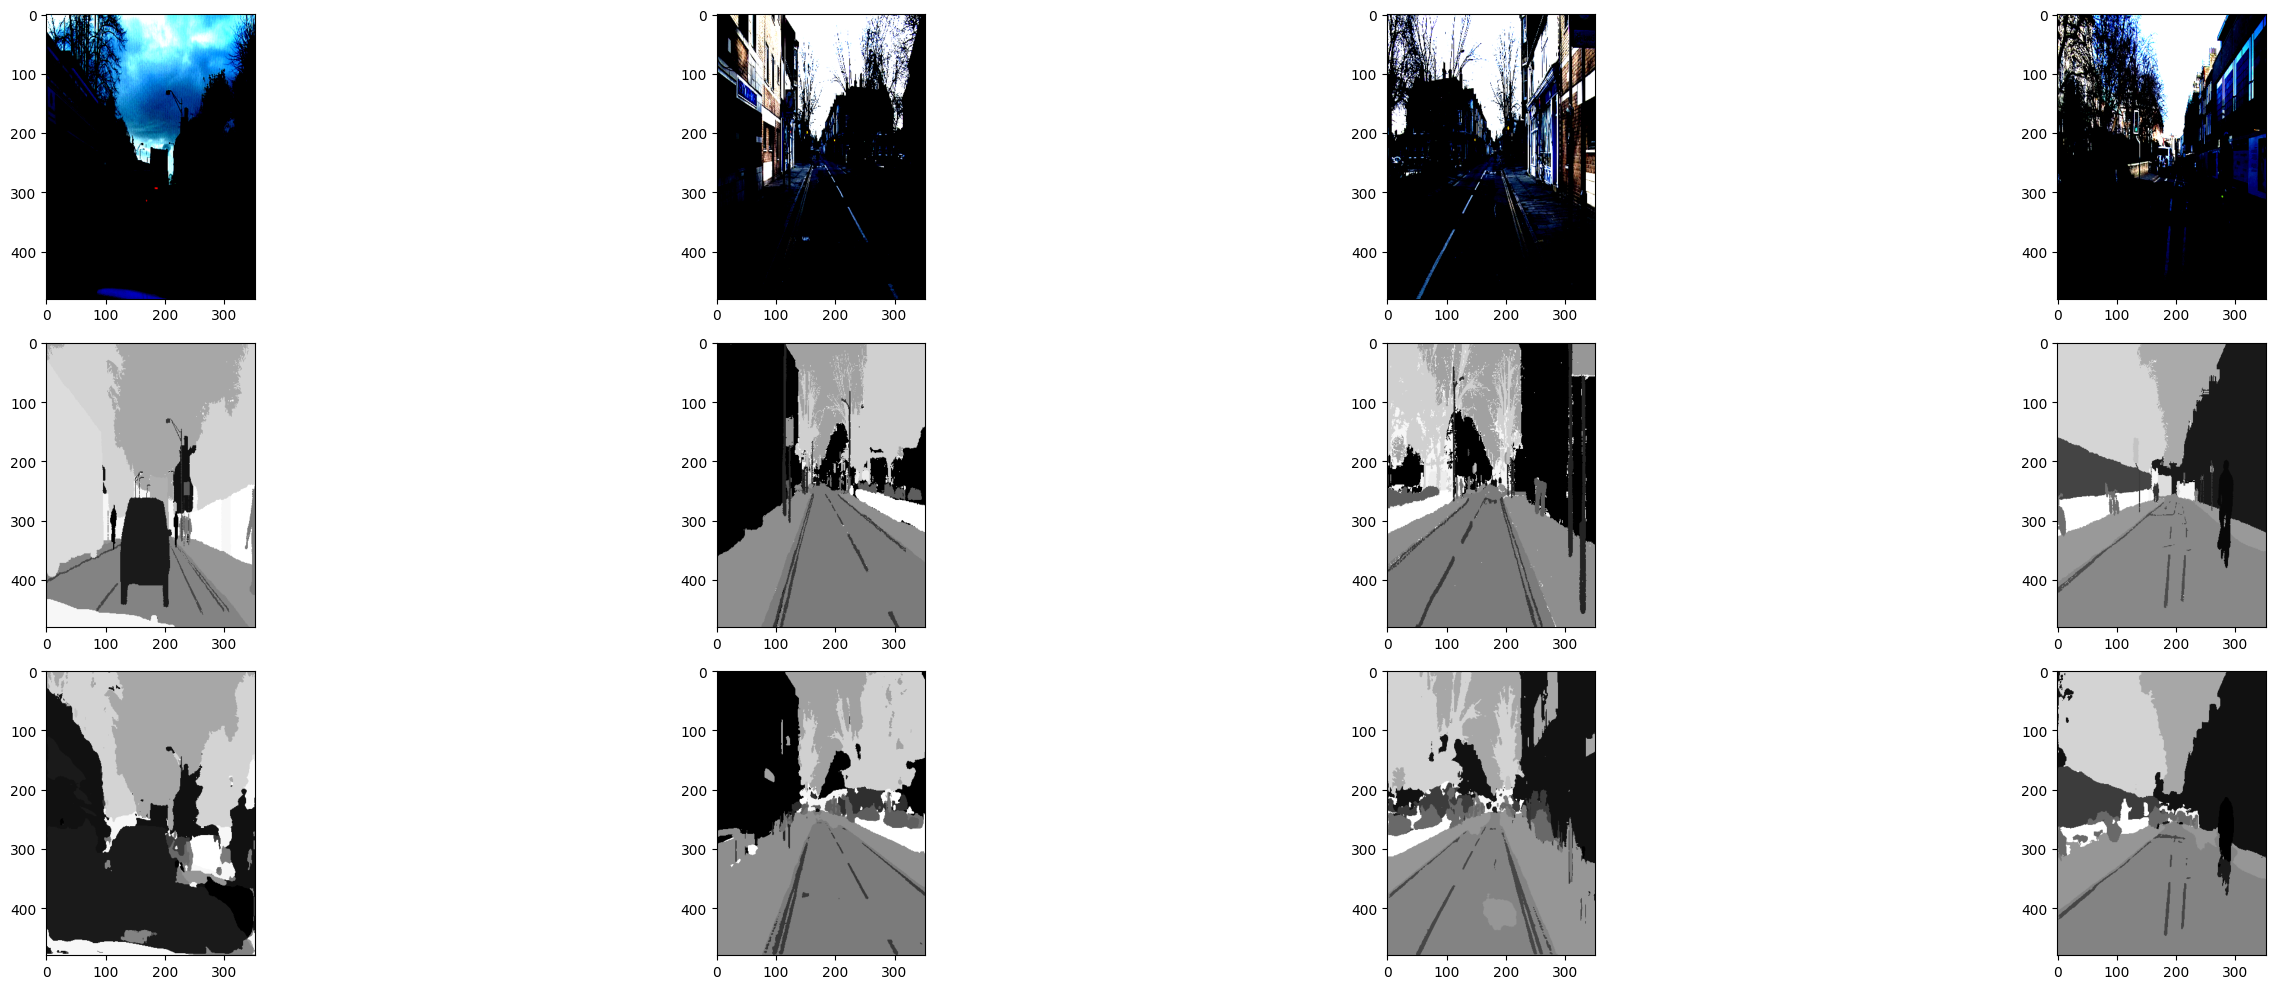

epoch 21/80 loss: 407045.685837766, acc: 0.004169486463069916, dic: 0.0035090676974505186, iou: 0.00292067788541317
epoch 21/80 val_loss: 547345.0432692308, val_acc: 0.004087969660758972, val_dic: 0.003308146260678768, val_iou: 0.0027064878959208727


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 22/80 loss: 384297.50216090423, acc: 0.004320729989558458, dic: 0.0036180338356643915, iou: 0.003013944486156106
epoch 22/80 val_loss: 536196.3677884615, val_acc: 0.004077612888067961, val_dic: 0.0033823952544480562, val_iou: 0.0028273342177271843


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 23/80 loss: 363306.25299202127, acc: 0.004493711981922388, dic: 0.0037494541611522436, iou: 0.003136951243504882
epoch 23/80 val_loss: 610982.3509615385, val_acc: 0.004202861338853836, val_dic: 0.003332989290356636, val_iou: 0.002702537225559354


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 24/80 loss: 365482.36461103725, acc: 0.004494524095207453, dic: 0.0037103737704455853, iou: 0.0030965835321694613
epoch 24/80 val_loss: 431443.90625, val_acc: 0.003980710636824369, val_dic: 0.0034172532614320517, val_iou: 0.0028442067559808493


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 25/80 loss: 356784.4990026596, acc: 0.004488615319132805, dic: 0.0037363420706242323, iou: 0.0031215690542012453
epoch 25/80 val_loss: 499097.13942307694, val_acc: 0.004314057994633913, val_dic: 0.0034380874130874872, val_iou: 0.002802525646984577


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 26/80 loss: 335921.95578457444, acc: 0.004630726296454668, dic: 0.003827151609584689, iou: 0.003198872786015272
epoch 26/80 val_loss: 542678.7427884615, val_acc: 0.004182014614343643, val_dic: 0.0033030316699296236, val_iou: 0.002666268264874816


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 27/80 loss: 334951.6126994681, acc: 0.0047587682493031025, dic: 0.0038720190059393644, iou: 0.0032370241824537516
epoch 27/80 val_loss: 395260.2451923077, val_acc: 0.004703885409981012, val_dic: 0.0037991947028785944, val_iou: 0.0031471620313823223


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 28/80 loss: 325149.3871343085, acc: 0.004753067158162594, dic: 0.003913036081939936, iou: 0.003278586082160473
epoch 28/80 val_loss: 411912.48317307694, val_acc: 0.0047190431505441666, val_dic: 0.003732727374881506, val_iou: 0.0031204265542328358


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 29/80 loss: 313964.4102393617, acc: 0.004885961767286062, dic: 0.003964005038142204, iou: 0.0033318251371383667
epoch 29/80 val_loss: 400115.8233173077, val_acc: 0.004592894110828638, val_dic: 0.0037920658942312002, val_iou: 0.003154104808345437


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 30/80 loss: 309038.4220412234, acc: 0.004864973481744528, dic: 0.003995531238615513, iou: 0.0033543952740728855
epoch 30/80 val_loss: 357656.0829326923, val_acc: 0.004600646905601025, val_dic: 0.003860285971313715, val_iou: 0.0032163129653781652


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


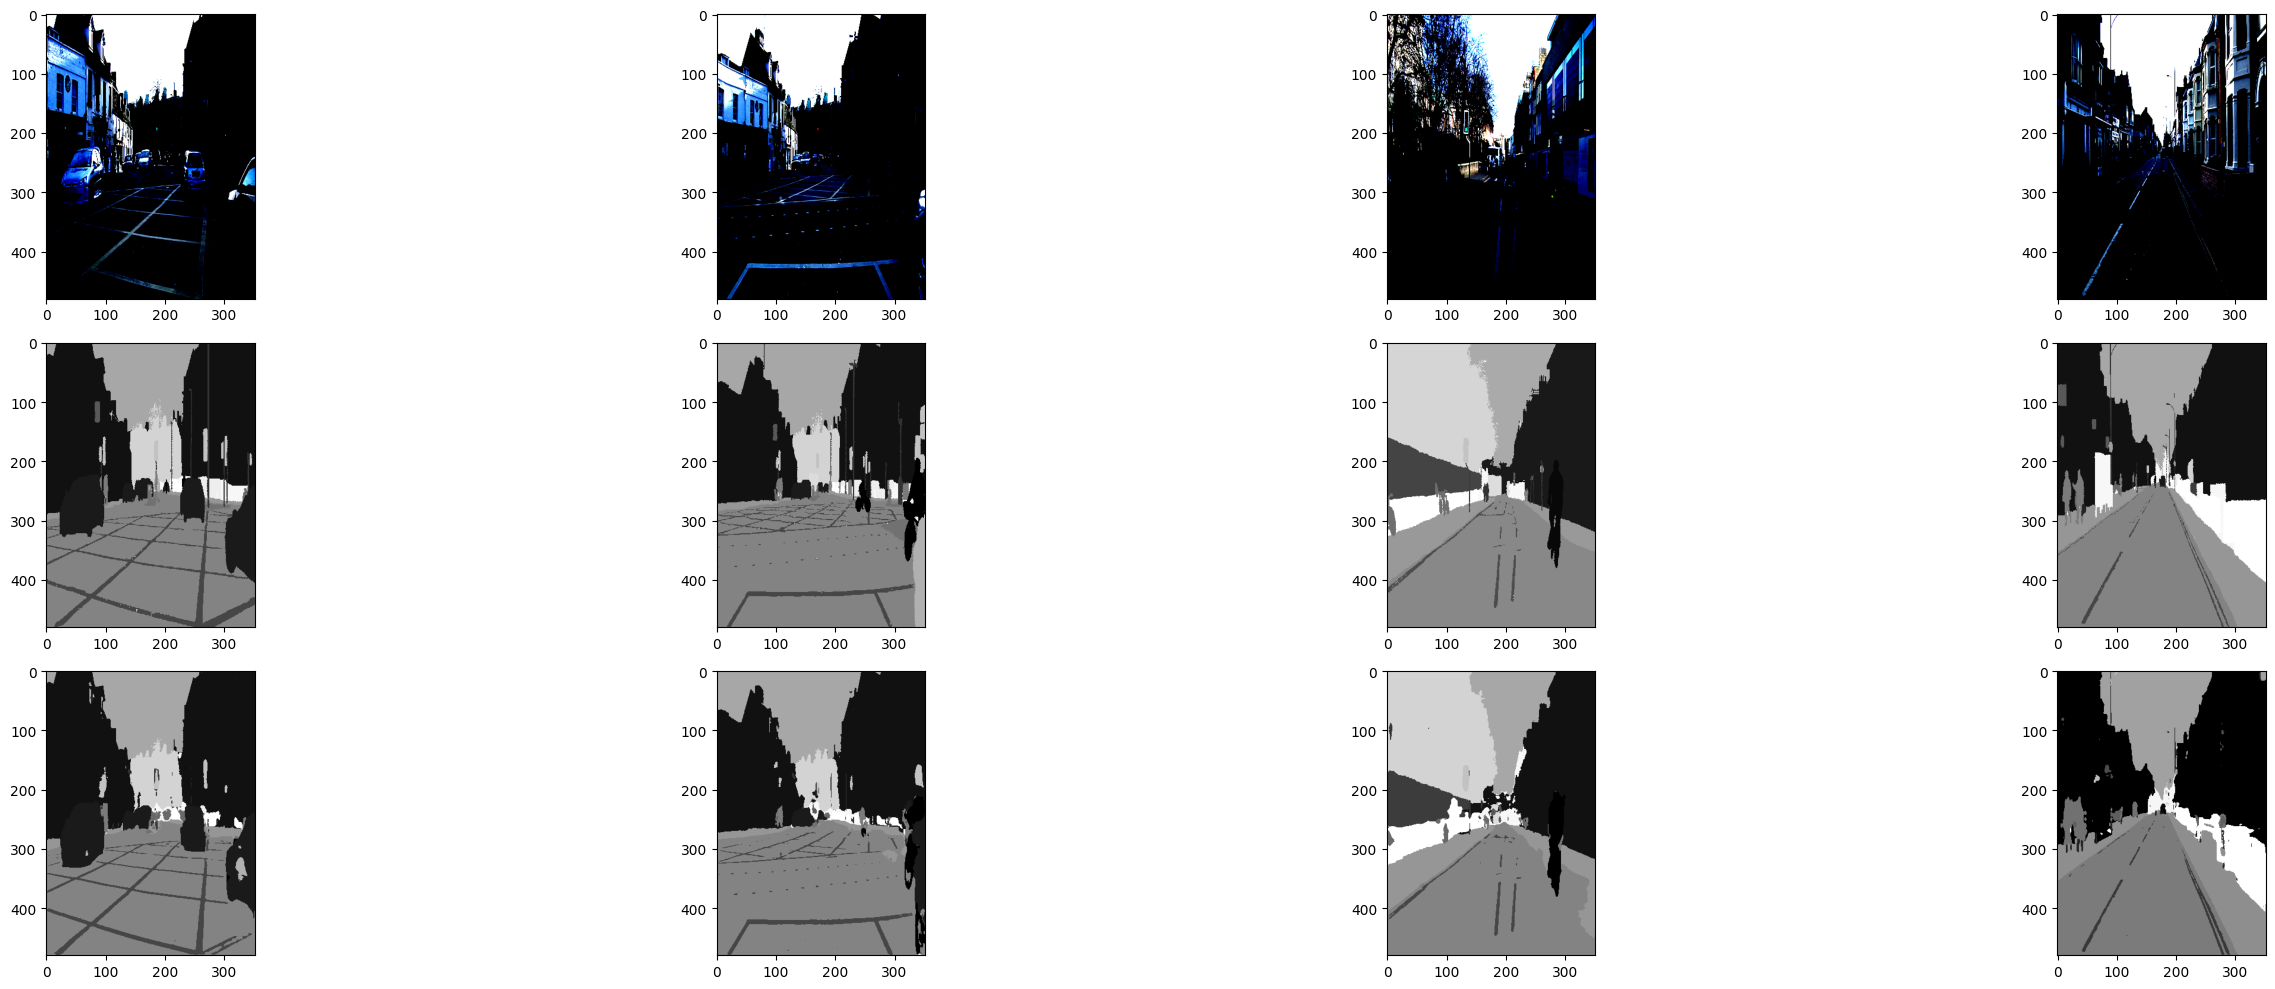

epoch 31/80 loss: 287051.50856050535, acc: 0.00510829221457243, dic: 0.00412583164870739, iou: 0.0034710222389549017
epoch 31/80 val_loss: 379059.74158653844, val_acc: 0.004879061598330736, val_dic: 0.003951167222112417, val_iou: 0.003286112332716584


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 32/80 loss: 286313.4794714096, acc: 0.005225711967796087, dic: 0.004142823163419962, iou: 0.0034840067382901907
epoch 32/80 val_loss: 369037.26682692306, val_acc: 0.004922876600176096, val_dic: 0.003907003905624151, val_iou: 0.0032428253907710314


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 33/80 loss: 280135.80834441487, acc: 0.005254782270640135, dic: 0.004158304538577795, iou: 0.0035032068844884634
epoch 33/80 val_loss: 385258.8485576923, val_acc: 0.004852721467614174, val_dic: 0.0038653737865388393, val_iou: 0.0032304415944963694


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 34/80 loss: 287880.4612699468, acc: 0.005208057351410389, dic: 0.004146082792431116, iou: 0.003483274020254612
epoch 34/80 val_loss: 330946.6376201923, val_acc: 0.00516554107889533, val_dic: 0.004070466849952936, val_iou: 0.0034064517822116613


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 35/80 loss: 265907.7659574468, acc: 0.005397487431764603, dic: 0.0042406609281897545, iou: 0.003569546388462186
epoch 35/80 val_loss: 341319.03245192306, val_acc: 0.00510338693857193, val_dic: 0.00408845953643322, val_iou: 0.0034142090007662773


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 36/80 loss: 246635.3041057181, acc: 0.005570551846176386, dic: 0.004365111701190472, iou: 0.0036881689447909594
epoch 36/80 val_loss: 318288.08653846156, val_acc: 0.005010117776691914, val_dic: 0.0040513151325285435, val_iou: 0.003391304751858115


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 37/80 loss: 241410.48503989363, acc: 0.005586095154285431, dic: 0.004373823758214712, iou: 0.0036955855321139097
epoch 37/80 val_loss: 313912.53846153844, val_acc: 0.005275705363601446, val_dic: 0.004187834449112415, val_iou: 0.0034763519652187824


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 38/80 loss: 237039.84375, acc: 0.005685498472303152, dic: 0.004453686065971851, iou: 0.0037669797893613577
epoch 38/80 val_loss: 388322.50360576925, val_acc: 0.005165917333215475, val_dic: 0.00400913879275322, val_iou: 0.0033471849747002125


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


epoch 39/80 loss: 226632.95196143616, acc: 0.00581762008368969, dic: 0.004491154104471207, iou: 0.00380440941080451
epoch 39/80 val_loss: 296382.98557692306, val_acc: 0.00536724179983139, val_dic: 0.004311045166105032, val_iou: 0.0036241295747458935


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 40/80 loss: 224817.3048537234, acc: 0.0057558282278478146, dic: 0.004503754433244467, iou: 0.0038143787533044815
epoch 40/80 val_loss: 281322.1875, val_acc: 0.0057393815368413925, val_dic: 0.00440119719132781, val_iou: 0.0037094594445079565


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


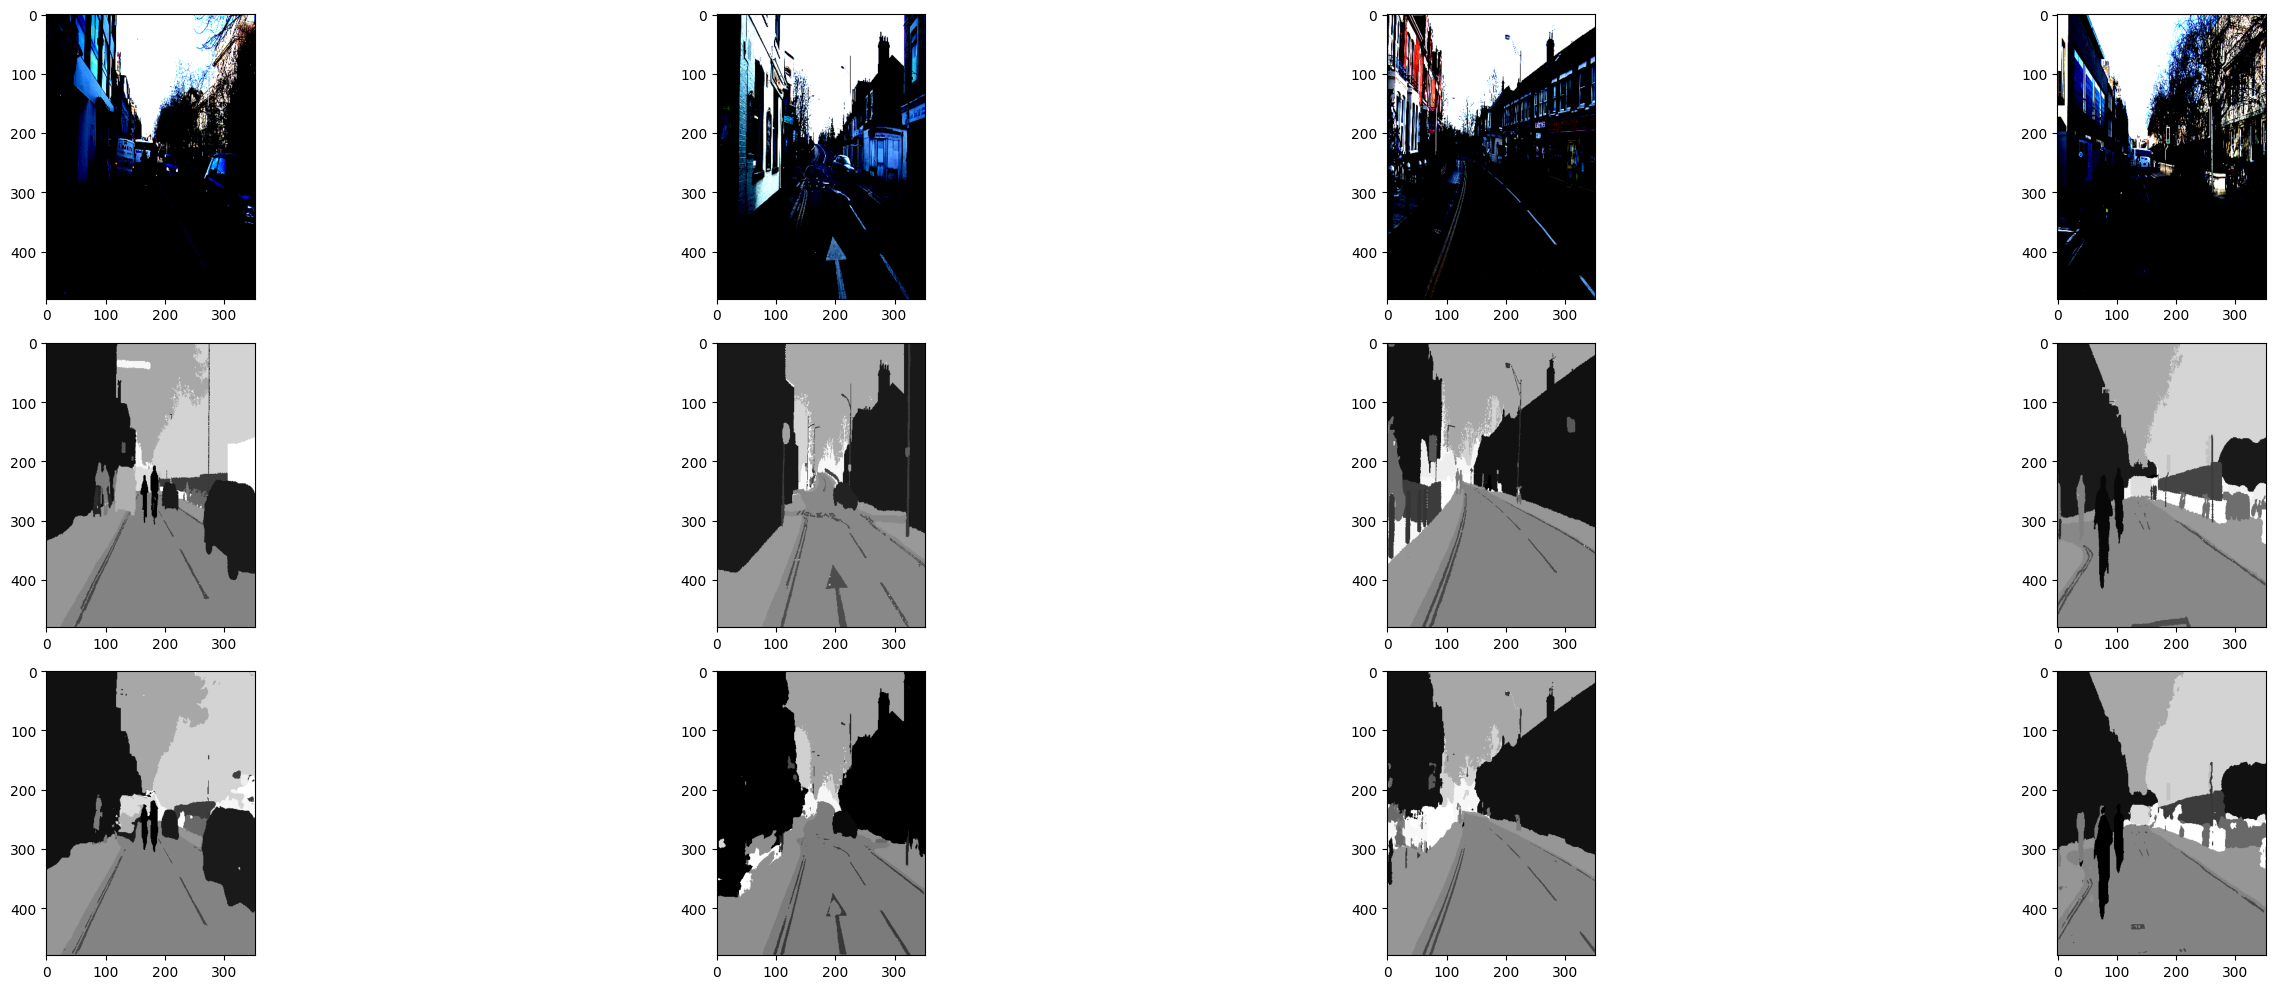

epoch 41/80 loss: 220327.34507978722, acc: 0.0057662115432322025, dic: 0.00450861593708396, iou: 0.0038255169056355953
epoch 41/80 val_loss: 305336.4633413461, val_acc: 0.005309157073497772, val_dic: 0.004177610389888287, val_iou: 0.003505496773868799


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 42/80 loss: 204744.27842420212, acc: 0.005982865579426289, dic: 0.004639911465346813, iou: 0.003944466356188059
epoch 42/80 val_loss: 296226.17067307694, val_acc: 0.005677253007888794, val_dic: 0.0044602700509130955, val_iou: 0.0037490087561309338


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


epoch 43/80 loss: 199566.833153258, acc: 0.006162590812891722, dic: 0.004744956269860268, iou: 0.004038942512124777
epoch 43/80 val_loss: 336409.24879807694, val_acc: 0.005615913309156895, val_dic: 0.004321355372667313, val_iou: 0.0036090335343033075


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 44/80 loss: 189820.49717420212, acc: 0.006226228084415197, dic: 0.004748981911689043, iou: 0.004043657798320055
epoch 44/80 val_loss: 326822.59735576925, val_acc: 0.0056554642505943775, val_dic: 0.004395646043121815, val_iou: 0.003687561023980379


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 45/80 loss: 185284.93134973405, acc: 0.006301485933363438, dic: 0.0048247091472148895, iou: 0.004110720008611679
epoch 45/80 val_loss: 277379.91466346156, val_acc: 0.005561895202845335, val_dic: 0.004359034355729818, val_iou: 0.003652447834610939


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 46/80 loss: 178159.1090425532, acc: 0.0063270144164562225, dic: 0.0048460084944963455, iou: 0.004132714122533798
epoch 46/80 val_loss: 273281.2554086539, val_acc: 0.005964246578514576, val_dic: 0.004546033684164286, val_iou: 0.003830459201708436


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 47/80 loss: 167833.98707613032, acc: 0.006652441341429949, dic: 0.0049828700721263885, iou: 0.004265943542122841
epoch 47/80 val_loss: 388277.9086538461, val_acc: 0.00588838430121541, val_dic: 0.004347834270447493, val_iou: 0.003626579884439707


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 48/80 loss: 166329.14544547873, acc: 0.006634857971221209, dic: 0.004988976288586855, iou: 0.004263778682798147
epoch 48/80 val_loss: 264746.9735576923, val_acc: 0.006077528931200504, val_dic: 0.004535791929811239, val_iou: 0.003831398207694292


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 49/80 loss: 159420.625831117, acc: 0.006755168549716473, dic: 0.005043595097959042, iou: 0.0043227793648839
epoch 49/80 val_loss: 266469.02764423075, val_acc: 0.0063986750319600105, val_dic: 0.004710549954324961, val_iou: 0.003958509769290686


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 50/80 loss: 155321.48936170212, acc: 0.006903819274157286, dic: 0.005117194727063179, iou: 0.00438996497541666
epoch 50/80 val_loss: 269459.43389423075, val_acc: 0.00616486044600606, val_dic: 0.004691051784902811, val_iou: 0.003954867832362652


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


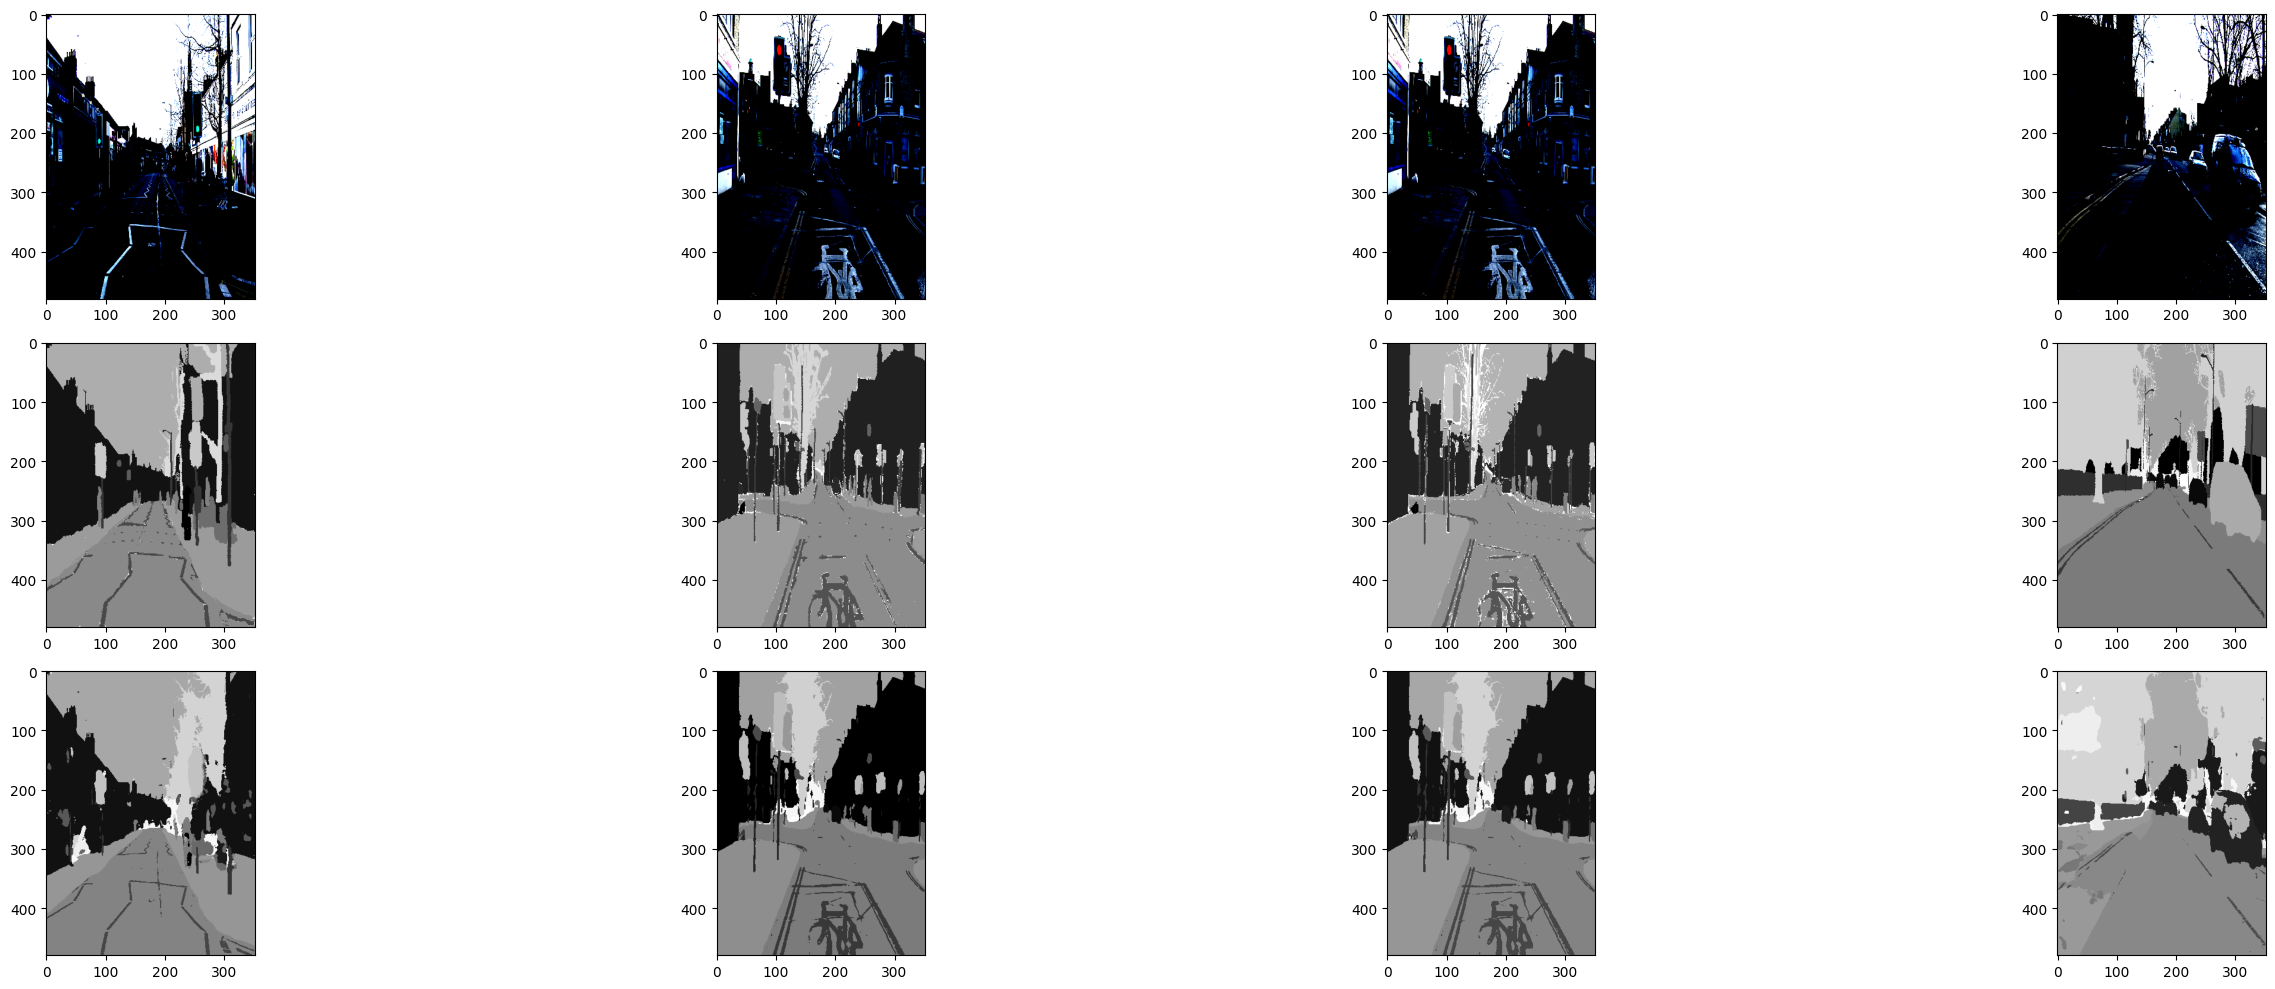

epoch 51/80 loss: 148848.01911569148, acc: 0.007006154395639896, dic: 0.005168449599295855, iou: 0.004438487812876701
epoch 51/80 val_loss: 272208.09375, val_acc: 0.006633554585278034, val_dic: 0.0048649548552930355, val_iou: 0.004106853157281876


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 52/80 loss: 143425.3673537234, acc: 0.0071534947492182255, dic: 0.0052370610646903515, iou: 0.004509657621383667
epoch 52/80 val_loss: 259912.65745192306, val_acc: 0.00647670729085803, val_dic: 0.0048394277691841125, val_iou: 0.004079082049429417


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 53/80 loss: 135779.02771775267, acc: 0.007430695462971926, dic: 0.005371535662561655, iou: 0.004636042285710573
epoch 53/80 val_loss: 258307.40865384616, val_acc: 0.006654879078269005, val_dic: 0.004914726596325636, val_iou: 0.004170335829257965


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 54/80 loss: 133415.1452584774, acc: 0.007290893234312534, dic: 0.005325686186552048, iou: 0.004601314663887024
epoch 54/80 val_loss: 269002.4765625, val_acc: 0.006562477443367243, val_dic: 0.004833967890590429, val_iou: 0.004083419684320688


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 55/80 loss: 126742.19888630319, acc: 0.007619291078299284, dic: 0.005429607816040516, iou: 0.004698974546045065
epoch 55/80 val_loss: 249945.83353365384, val_acc: 0.006466049700975418, val_dic: 0.004929570015519857, val_iou: 0.004189854487776756


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 56/80 loss: 120358.58095079787, acc: 0.00761147728189826, dic: 0.0054730018600821495, iou: 0.004739843774586916
epoch 56/80 val_loss: 258868.94350961538, val_acc: 0.006916440557688475, val_dic: 0.005000178702175617, val_iou: 0.004231850150972605


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 57/80 loss: 117612.1675531915, acc: 0.007892576977610588, dic: 0.005567559506744146, iou: 0.004830081015825272
epoch 57/80 val_loss: 247931.17427884616, val_acc: 0.006766872946172953, val_dic: 0.0049932715483009815, val_iou: 0.004255593754351139


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 58/80 loss: 112048.38887965426, acc: 0.008000846020877361, dic: 0.005627658683806658, iou: 0.004892420955002308
epoch 58/80 val_loss: 250532.95853365384, val_acc: 0.006883830763399601, val_dic: 0.005027117673307657, val_iou: 0.004278374835848808


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 59/80 loss: 108338.03848071808, acc: 0.008142884820699692, dic: 0.005683454219251871, iou: 0.004950071685016155
epoch 59/80 val_loss: 246689.75360576922, val_acc: 0.0070975287817418575, val_dic: 0.005077562294900417, val_iou: 0.004324129782617092


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 60/80 loss: 106916.05049035905, acc: 0.008081627078354359, dic: 0.005707881413400173, iou: 0.004975263494998217
epoch 60/80 val_loss: 253374.50180288462, val_acc: 0.006919547449797392, val_dic: 0.005017788149416447, val_iou: 0.0042702676728367805


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


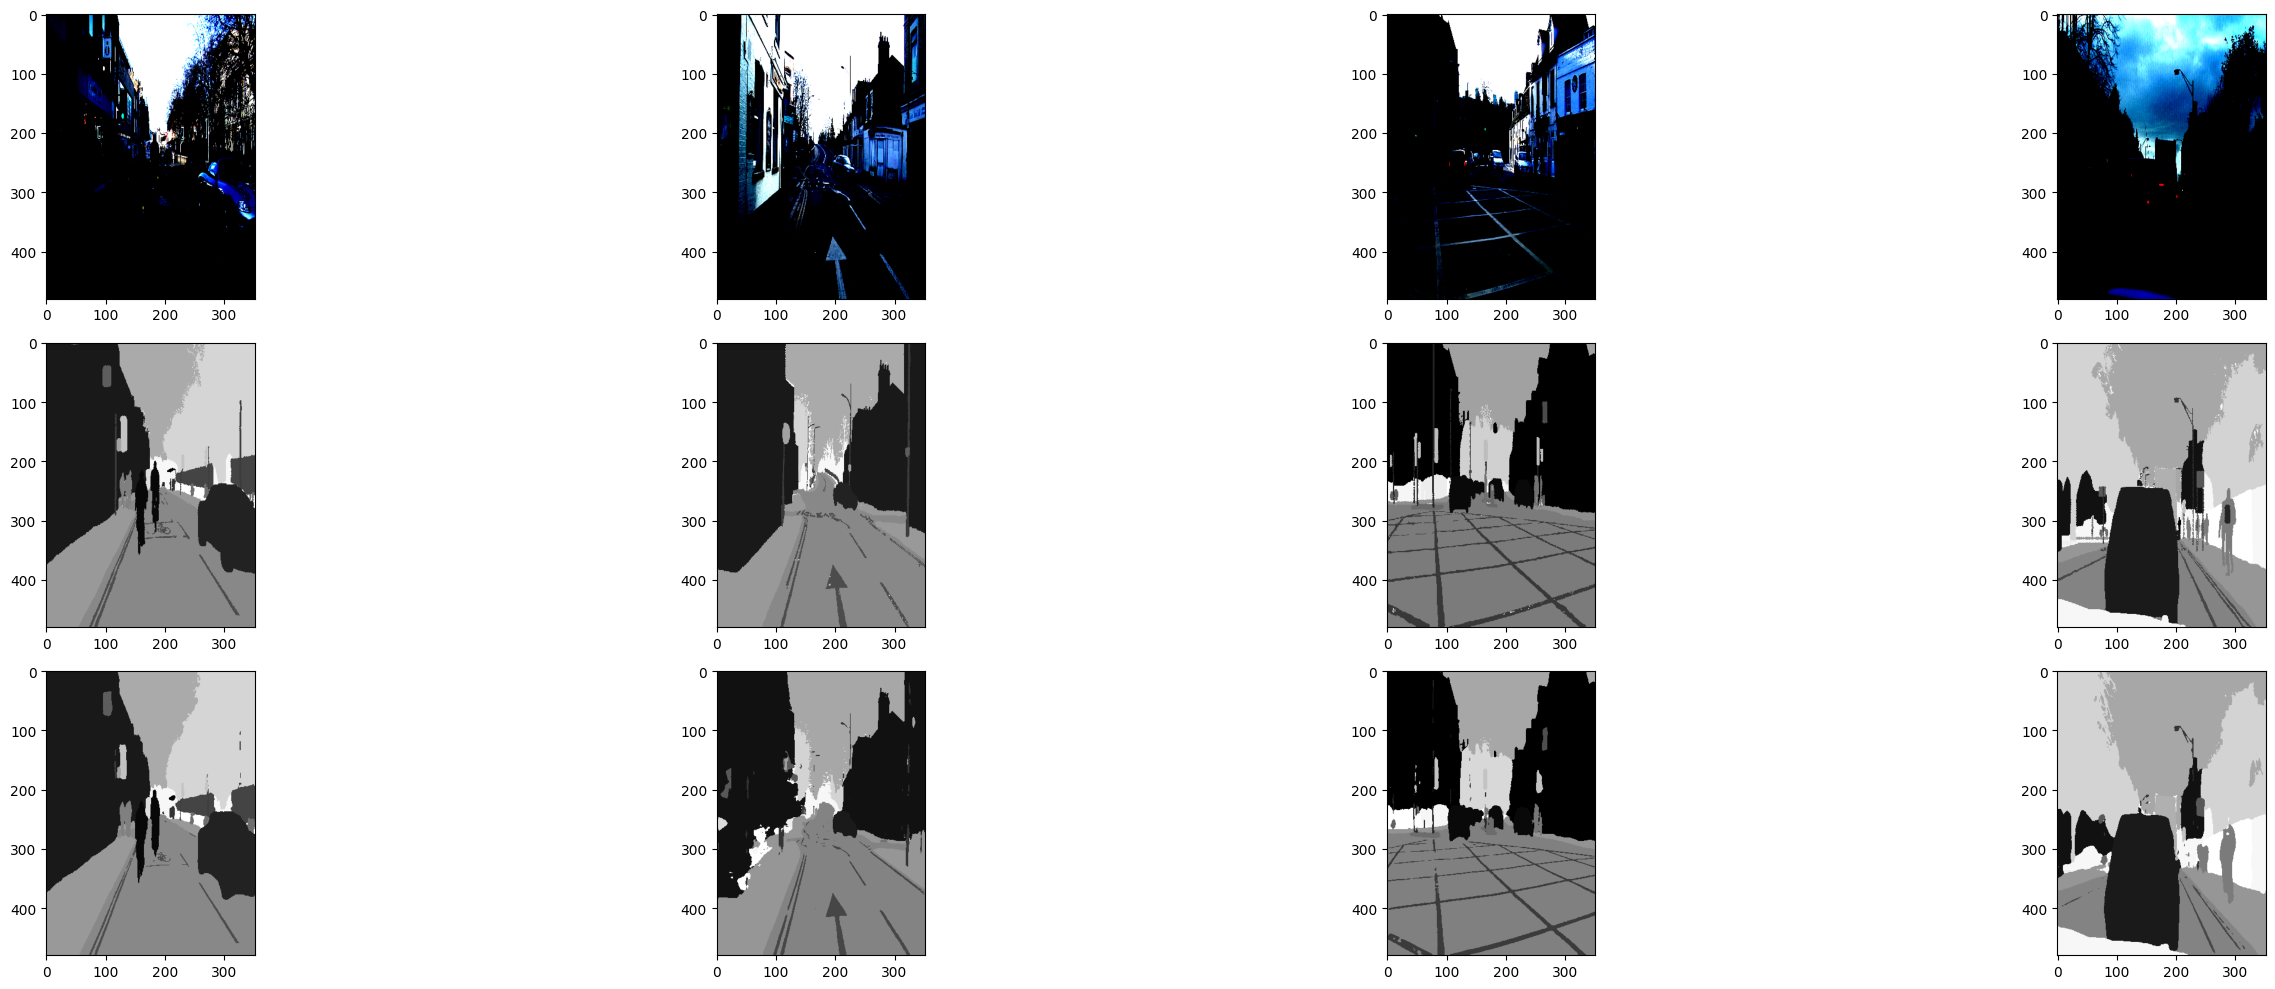

epoch 61/80 loss: 100288.7797124335, acc: 0.008373424410820007, dic: 0.00581778772175312, iou: 0.0050842901691794395
epoch 61/80 val_loss: 252646.65204326922, val_acc: 0.007165825460106134, val_dic: 0.005133337341248989, val_iou: 0.004376716911792755


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 62/80 loss: 97131.18496509308, acc: 0.008462030440568924, dic: 0.005876027513295412, iou: 0.005145649425685406
epoch 62/80 val_loss: 256035.25180288462, val_acc: 0.007301079109311104, val_dic: 0.00517147034406662, val_iou: 0.004406339954584837


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 63/80 loss: 95237.31902426861, acc: 0.008477523922920227, dic: 0.005923593882471323, iou: 0.005190683528780937
epoch 63/80 val_loss: 245925.60817307694, val_acc: 0.007016757503151894, val_dic: 0.0051077790558338165, val_iou: 0.004355290438979864


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 64/80 loss: 92930.14482214095, acc: 0.008573607541620731, dic: 0.005919917486608028, iou: 0.005191557575017214
epoch 64/80 val_loss: 255126.89963942306, val_acc: 0.007071308325976133, val_dic: 0.005093506071716547, val_iou: 0.004346275236457586


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 65/80 loss: 90058.16058219747, acc: 0.008634991943836212, dic: 0.006011328659951687, iou: 0.005275465548038483
epoch 65/80 val_loss: 245836.5703125, val_acc: 0.007194079924374819, val_dic: 0.00521378219127655, val_iou: 0.004449151922017336


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 66/80 loss: 88052.39926861702, acc: 0.008745189756155014, dic: 0.0059789507649838924, iou: 0.005253872834146023
epoch 66/80 val_loss: 252855.60396634616, val_acc: 0.00729250768199563, val_dic: 0.005138781853020191, val_iou: 0.004388934001326561


100%|██████████| 47/47 [00:31<00:00,  1.48it/s]


epoch 67/80 loss: 87607.35837765958, acc: 0.00880302395671606, dic: 0.005998711567372084, iou: 0.005270142108201981
epoch 67/80 val_loss: 250828.90264423078, val_acc: 0.007299535907804966, val_dic: 0.005161745008081198, val_iou: 0.004401915706694126


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 68/80 loss: 84633.8946143617, acc: 0.008806674741208553, dic: 0.006025837268680334, iou: 0.0053053954616189
epoch 68/80 val_loss: 247998.37740384616, val_acc: 0.007253360003232956, val_dic: 0.005234916228801012, val_iou: 0.004472700413316488


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 69/80 loss: 83851.09499667553, acc: 0.008840132504701614, dic: 0.006031599827110767, iou: 0.005313881207257509
epoch 69/80 val_loss: 255432.46514423078, val_acc: 0.007336149923503399, val_dic: 0.005181272514164448, val_iou: 0.004422682803124189


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 70/80 loss: 81338.5313331117, acc: 0.008929846808314323, dic: 0.006089506670832634, iou: 0.0053714062087237835
epoch 70/80 val_loss: 254861.76442307694, val_acc: 0.007499109487980604, val_dic: 0.005215335171669722, val_iou: 0.004448599647730589


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


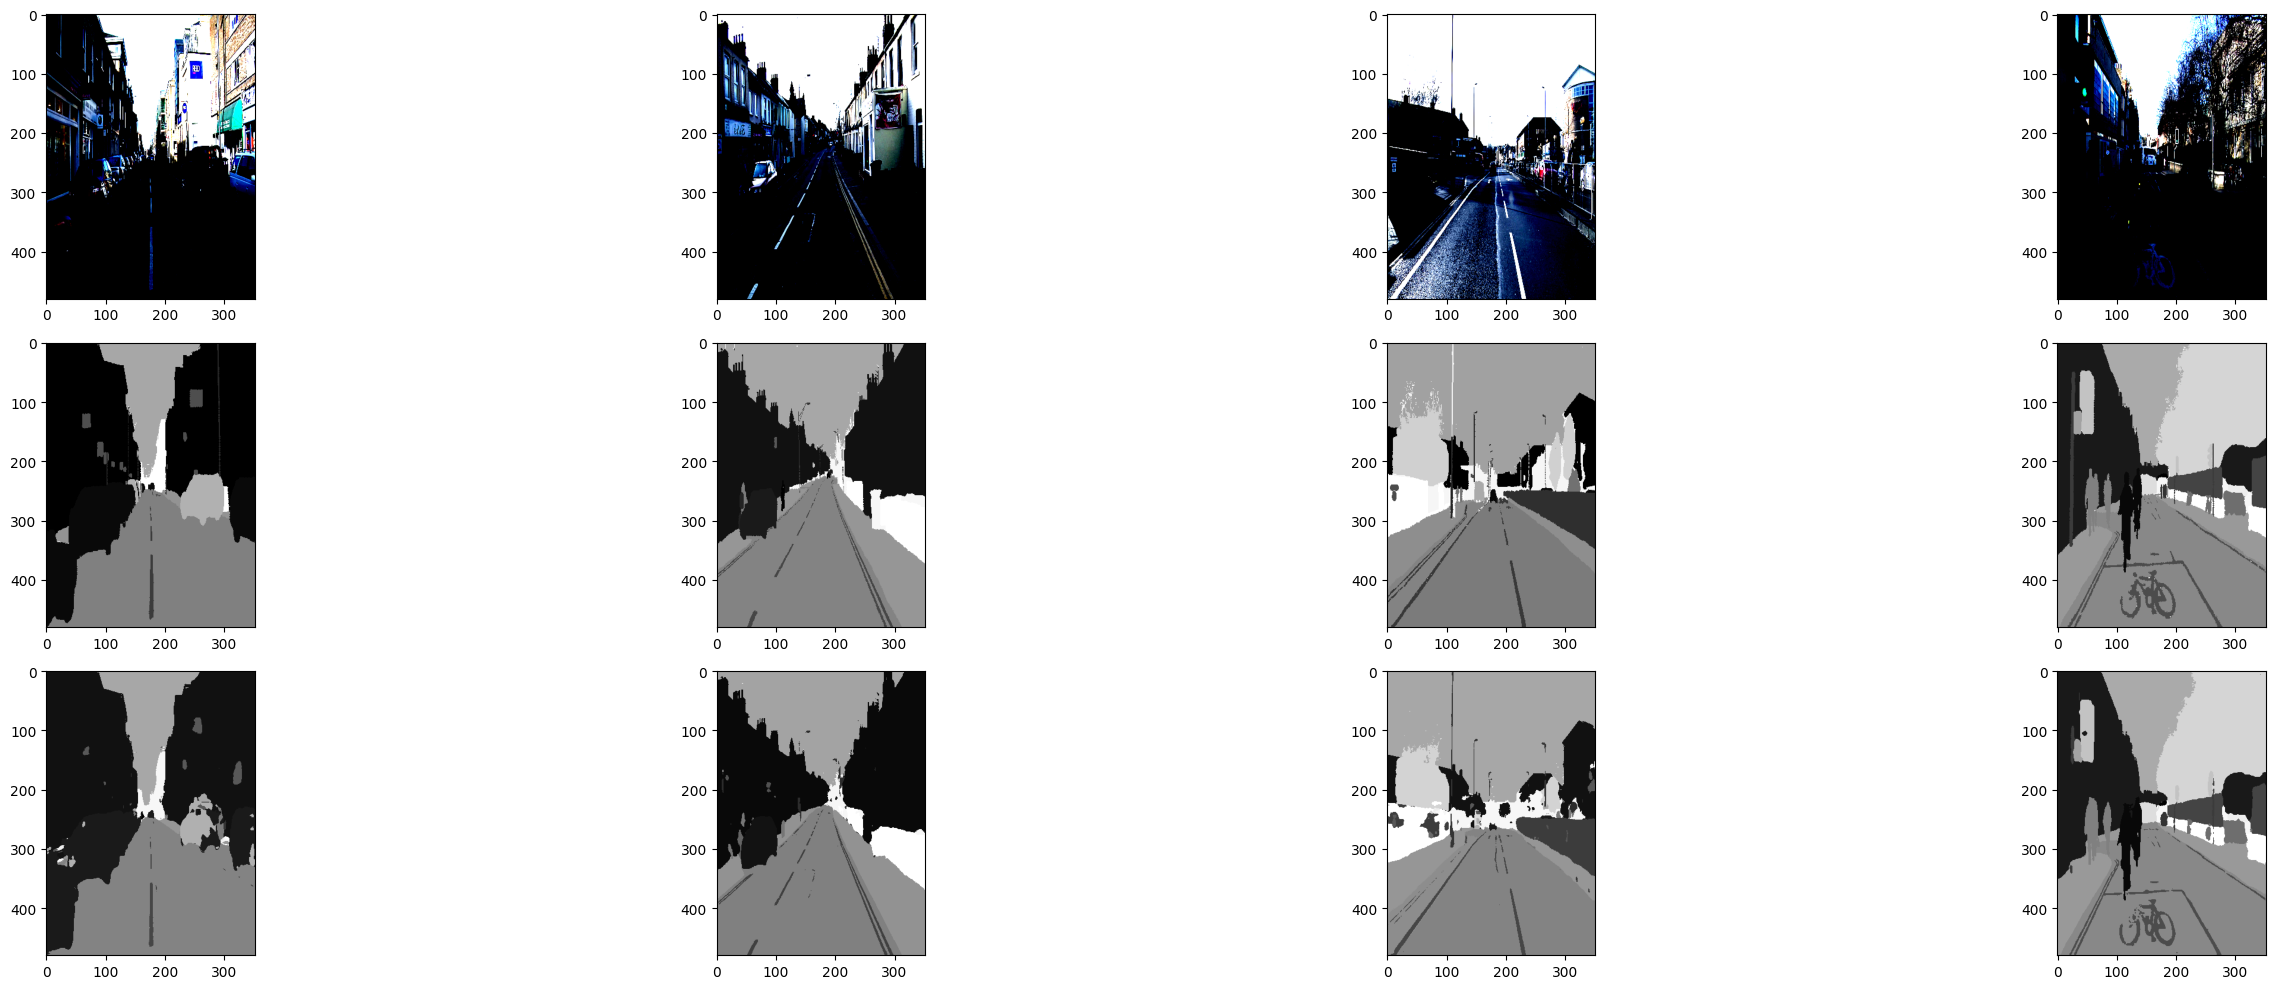

epoch 71/80 loss: 80537.85255984042, acc: 0.009044734761118889, dic: 0.006093937903642654, iou: 0.00537271099165082
epoch 71/80 val_loss: 252590.36298076922, val_acc: 0.007457016501575708, val_dic: 0.005216352641582489, val_iou: 0.004458474460989237


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 72/80 loss: 79243.48936170213, acc: 0.008893868885934353, dic: 0.006128672976046801, iou: 0.005409404169768095
epoch 72/80 val_loss: 256073.13942307694, val_acc: 0.0074188620783388615, val_dic: 0.005250290967524052, val_iou: 0.0044792937114834785


100%|██████████| 47/47 [00:31<00:00,  1.47it/s]


epoch 73/80 loss: 77450.08273769947, acc: 0.00908020418137312, dic: 0.00612621707841754, iou: 0.005414088722318411
epoch 73/80 val_loss: 260803.1045673077, val_acc: 0.007528853137046099, val_dic: 0.0052915336564183235, val_iou: 0.0045209056697785854


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 74/80 loss: 76984.35711020611, acc: 0.009026484563946724, dic: 0.006148212589323521, iou: 0.0054360805079340935
epoch 74/80 val_loss: 259106.83413461538, val_acc: 0.0074314516969025135, val_dic: 0.0052013034000992775, val_iou: 0.00444315979257226


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 75/80 loss: 76721.48894614361, acc: 0.00916922278702259, dic: 0.0061611575074493885, iou: 0.005444965325295925
epoch 75/80 val_loss: 257117.32992788462, val_acc: 0.007574683055281639, val_dic: 0.005246745888143778, val_iou: 0.0044819749891757965


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 76/80 loss: 76810.18982712766, acc: 0.009058527648448944, dic: 0.006154809147119522, iou: 0.005439187400043011
epoch 76/80 val_loss: 257369.37620192306, val_acc: 0.007360837422311306, val_dic: 0.005242219660431147, val_iou: 0.004479292314499617


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 77/80 loss: 76045.37840757979, acc: 0.00901949405670166, dic: 0.006166995503008366, iou: 0.005454570986330509
epoch 77/80 val_loss: 260715.66646634616, val_acc: 0.007506472058594227, val_dic: 0.00523947412148118, val_iou: 0.004478098824620247


100%|██████████| 47/47 [00:31<00:00,  1.49it/s]


epoch 78/80 loss: 75136.28241356384, acc: 0.009074113331735134, dic: 0.0062059625051915646, iou: 0.0054860166274011135
epoch 78/80 val_loss: 257065.11057692306, val_acc: 0.007286583073437214, val_dic: 0.005268246866762638, val_iou: 0.0045039053075015545


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 79/80 loss: 76028.5231881649, acc: 0.009189737029373646, dic: 0.006194278597831726, iou: 0.005475542973726988
epoch 79/80 val_loss: 257179.22836538462, val_acc: 0.00753500172868371, val_dic: 0.005260982550680637, val_iou: 0.004499069415032864


100%|██████████| 47/47 [00:31<00:00,  1.50it/s]


epoch 80/80 loss: 75494.96854222074, acc: 0.009097518399357796, dic: 0.006201013922691345, iou: 0.005483664106577635
epoch 80/80 val_loss: 258077.57932692306, val_acc: 0.007210512179881334, val_dic: 0.005224723368883133, val_iou: 0.0044563040137290955


In [21]:
train_hist = []
val_hist = []
for epoch in range(epochs):
    model.train()
    running_dice = 0
    running_iou = 0
    running_acc = 0
    running_loss = 0
    
    for image, mask in tqdm(train_loader):
        image, mask = image.to(device), mask.to(device)

        optimizer.zero_grad()
        pred = model(image)
        loss = criterion(pred, mask)
        running_loss += loss.item()
        a = accuracy(pred, mask)
        d = dice(pred, mask)
        i = iou(pred, mask)
        
        running_acc += a
        running_dice += d
        running_iou += i
        
        train_hist.append((loss.item(), a, d, i))
                
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
        optimizer.step()
        lr_scheduler.step()
    running_acc /= len(train_loader)
    running_dice /= len(train_loader)
    running_iou /= len(train_loader)
    running_loss /= len(train_loader)
    
    model.eval()
    val_acc = 0
    val_dice = 0
    val_iou = 0
    val_loss = 0
    with torch.no_grad():
        for image, mask in val_loader:
            image, mask = image.to(device), mask.to(device)
            pred = model(image)

            loss = criterion(pred, mask)
            a = accuracy(pred, mask)
            d = dice(pred, mask)
            i = iou(pred, mask)
            
            val_loss += loss.item()
            val_acc += a
            val_dice += d
            val_iou += i

            val_hist.append((loss.item(), a, d, i))

        val_acc /= len(val_loader)
        val_dice /= len(val_loader)
        val_iou /= len(val_loader)
        val_loss /= len(val_loader)

        if not epoch%10:
            num_rows = 3
            image = image[:4]
            mask = mask[:4]
            pred = pred[:4]
            num_cols = len(image)
            fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 10))
            
            for i in range(num_cols):
                axes[0, i].imshow(image[i].permute(1, 2, 0).cpu())
                axes[1, i].imshow(mask[i].cpu(), cmap="gray")
                # print(torch.unique(pred[i].argmax(0)), pred.size())
                axes[2, i].imshow(pred[i].argmax(0).cpu(), cmap="gray")
            
            plt.tight_layout()
            plt.show()

            # tracker(pred, mask, loss=loss.item())
    print(f"epoch {epoch+1}/{epochs} loss: {running_loss}, acc: {running_acc}, dic: {running_dice}, iou: {running_iou}")
    print(f"epoch {epoch+1}/{epochs} val_loss: {val_loss}, val_acc: {val_acc}, val_dic: {val_dice}, val_iou: {val_iou}")

In [29]:
model_path = "camvid-seg-model.pth"
torch.save(model.state_dict(), model_path)

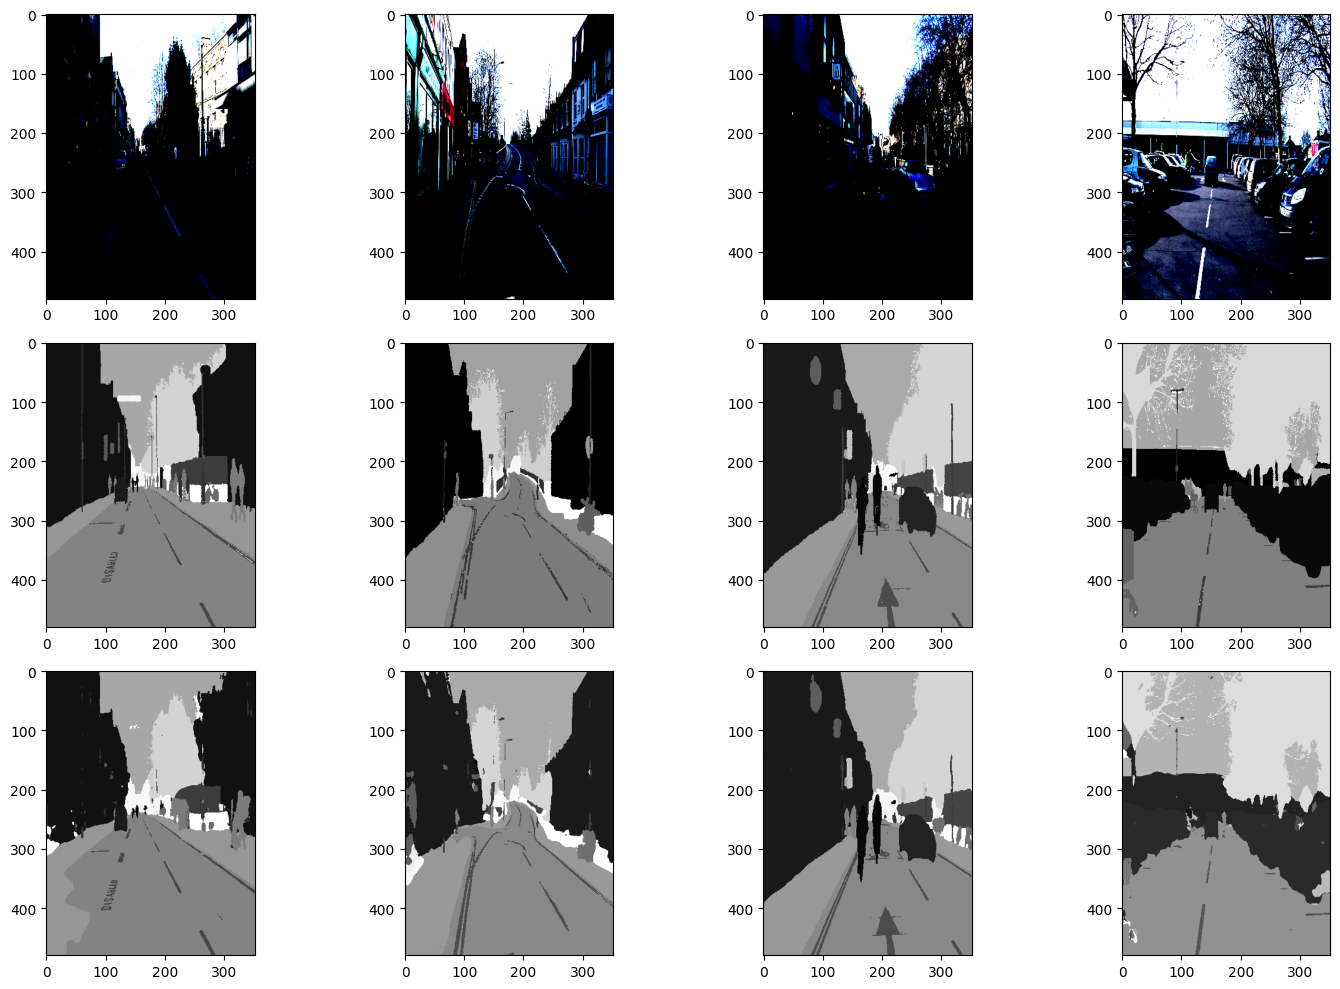

In [36]:
for image, mask in test_loader:
    image, mask = image.to(device), mask.to(device)
    break
num_rows = 3
image = image[:4]
mask = mask[:4]
pred = model(image)
pred = pred[:4]
num_cols = len(image)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 10))
for i in range(num_cols):
    axes[0, i].imshow(image[i].permute(1, 2, 0).cpu())
    axes[1, i].imshow(mask[i].cpu(), cmap="gray")
    # print(torch.unique(pred[i].argmax(0)), pred.size())
    axes[2, i].imshow(pred[i].argmax(0).cpu(), cmap="gray")

plt.tight_layout()
plt.show()

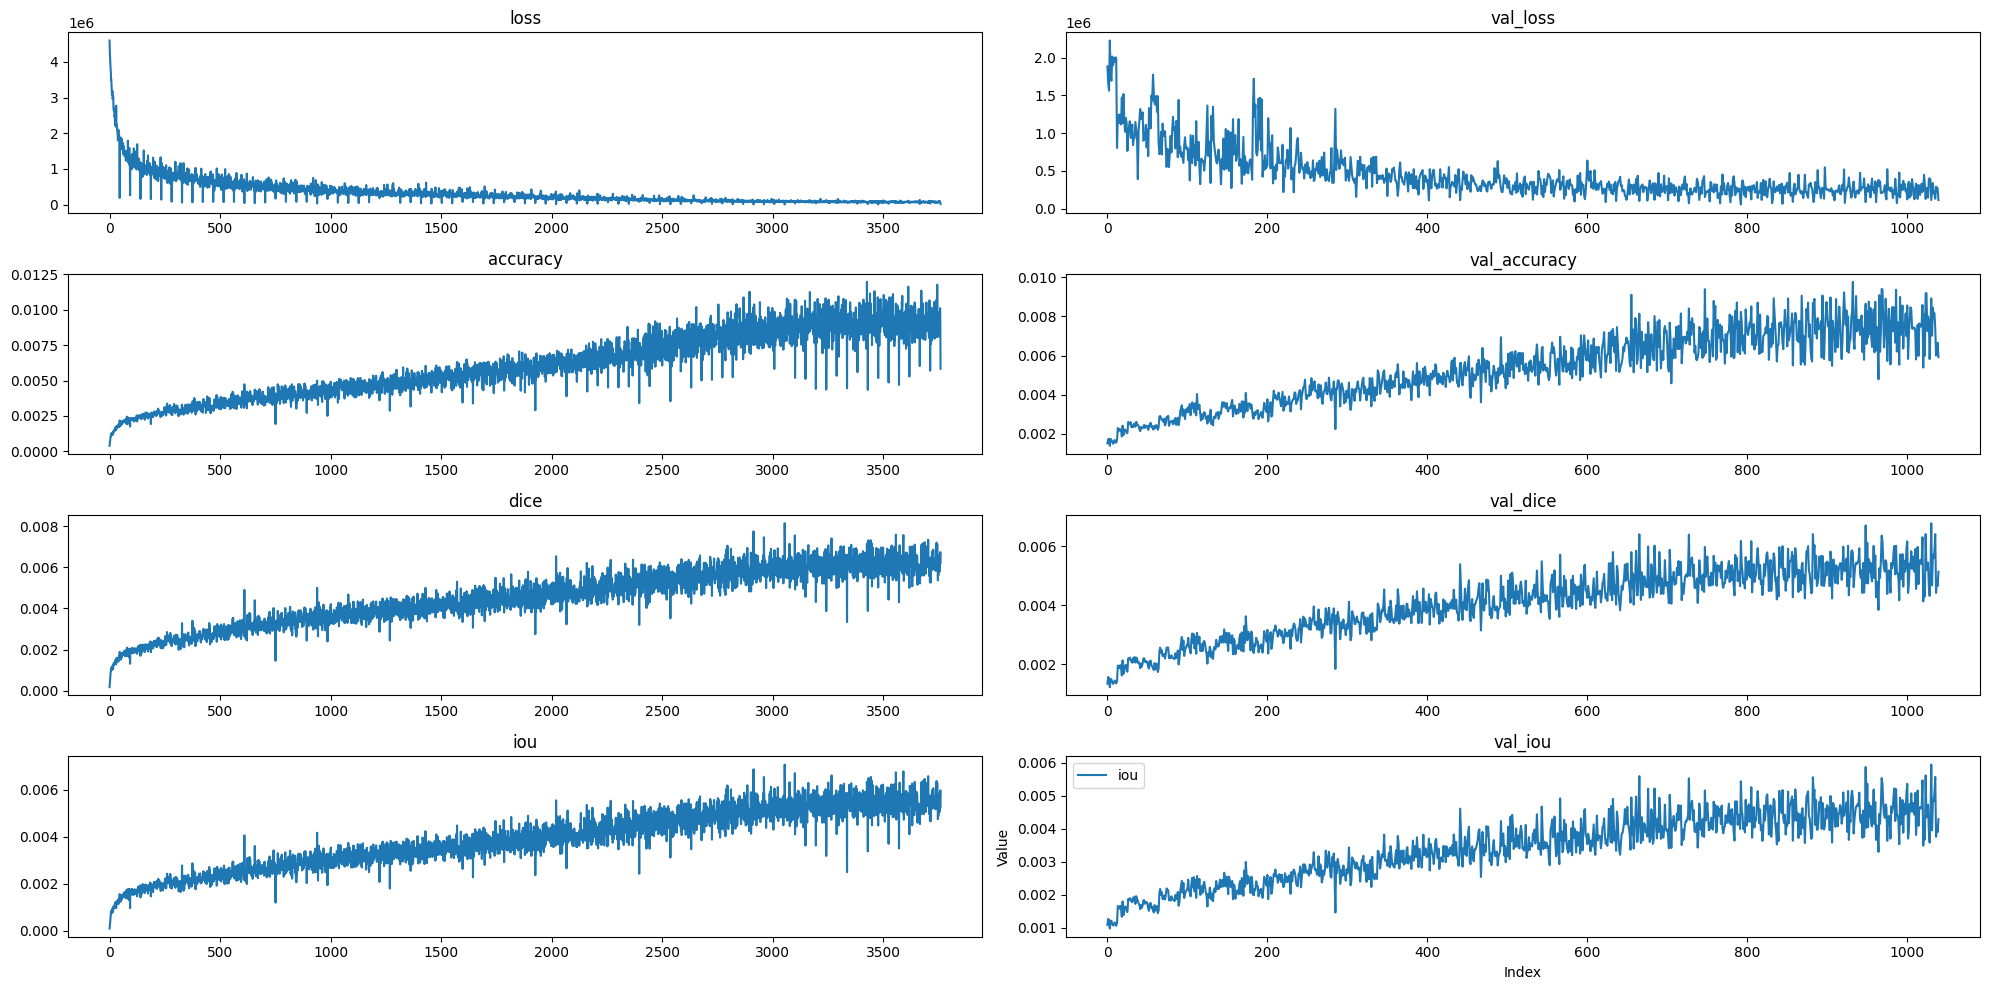

In [26]:
hists = [train_hist, val_hist]
metrics = ["loss", "accuracy", "dice", "iou"]

fig, axes = plt.subplots(len(metrics), 2, figsize=(20, 10))

for hi, hist in enumerate(hists):
    for i, m in enumerate(metrics):
        # print(m)
        if m in  ["accuracy", "dice", "iou"]:
            line = [row[i].cpu() for row in hist]
        else:
            line = [row[i] for row in hist]

        # print(line[:4])
        axes[i, hi].plot(line, label=m)
        axes[i, hi].set_title(f"{'val_' if hist == val_hist else ''}" + m)
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.legend()
    plt.grid()

plt.tight_layout()
plt.show()

In [30]:
trained_model_weights = torch.load(model_path, weights_only=True, map_location=torch.device('cpu'))

In [31]:
model = UNet(3, num_classes).to(device)

In [32]:
model.load_state_dict(trained_model_weights)

<All keys matched successfully>